In [ ]:
# Libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import random
import sklearn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Remove printing error
pd.options.mode.chained_assignment = None

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

from typing import Counter
import imblearn
from imblearn.over_sampling import SMOTE

from functions_folder.nn_MIMICDataset import MIMICDataset
from functions_folder.nn_train import train
from functions_folder.nn_evaluate import evaluate
from functions_folder.nn_equalized_odds import equalised_odds
from functions_folder.short import *
from functions_folder.specific_antibiotics import specific_antibiotics
from functions_folder.asi import calculate_asi
import scipy.stats as stats
from numpy import mean
from numpy import std

In [2]:
# Set the random seeds for deterministic results.
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### Treatment day

In [10]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')

# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag', 'iv_treatment_length'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

stays = hold_out_data['stay_id'].unique()
random.Random(22).shuffle(stays) # Best split from CV

X_data = hold_out_data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag', 'iv_treatment_length'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
model_data = pd.concat([hold_out_data[['stay_id', 'po_flag', 'iv_treatment_length']], X_data], axis=1)
model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.7 * len(stays))
n2 = round(0.85 * len(stays))
train_stays = stays[:n]
validation_stays = stays[n:n2]
test_stays = stays[n2:]
train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
test_data = model_data2[model_data2['stay_id'].isin(test_stays)]

In [11]:
# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

model.load_state_dict(torch.load('hold_out_switch_model_short.pt'))

# Define batch size 
batch_size = 256

# Define loss
criterion = nn.BCEWithLogitsLoss()

<All keys matched successfully>

In [12]:
treatment_length_df = pd.DataFrame()

for i in test_data.iv_treatment_length.unique():
    print(i)
    temp_test_data = test_data[test_data['iv_treatment_length'] == i]
    temp_test_data = temp_test_data.drop(columns=['iv_treatment_length'])

    temp_test_dataset = MIMICDataset(temp_test_data)
    temp_test_dataloader = DataLoader(dataset=temp_test_dataset, batch_size=batch_size, collate_fn=temp_test_dataset.collate_fn_padd)

    test_loss, test_accuracy, test_auroc, test_predictions, test_labels = evaluate(model, temp_test_dataloader, criterion)

    # Use new cut off
    lower_bound_test_predictions, upper_bound_test_predictions = new_threshold_fun(test_predictions)

    print(np.unique(test_labels, return_counts=True))
    print(np.unique(lower_bound_test_predictions, return_counts=True))
    print(np.unique(upper_bound_test_predictions, return_counts=True))

    label_values, label_counts = np.unique(test_labels, return_counts=True)
    lower_bound_values, lower_bound_counts =np.unique(lower_bound_test_predictions, return_counts=True)
    upper_bound_values, upper_bound_counts =np.unique(upper_bound_test_predictions, return_counts=True)

    label_0 = 0
    label_1 = 0
    for x in range(len(label_values)):
        if label_values[x] == 0:
            label_0 = label_counts[x]
        elif label_values[x] == 1:
            label_1 = label_counts[x]
    prediction_0 = 0
    prediction_1 = 0
    for x in range(len(lower_bound_values)):
        if lower_bound_values[x] == 0:
            prediction_0 = lower_bound_counts[x]
        elif lower_bound_values[x] == 1:
            prediction_1 = lower_bound_counts[x]
    ub_prediction_0 = 0
    ub_prediction_1 = 0
    for x in range(len(upper_bound_values)):
        if upper_bound_values[x] == 0:
            ub_prediction_0 = upper_bound_counts[x]
        elif upper_bound_values[x] == 1:
            ub_prediction_1 = upper_bound_counts[x]

    # Lower bound
    try:
        test_auroc2 = roc_auc_score(test_labels, lower_bound_test_predictions)
    except:
        test_auroc2 = np.nan
    #print('Test AUROC result 2:', test_auroc2)
    test_accuracy2 = accuracy_score(test_labels, lower_bound_test_predictions)
    #assert test_accuracy == test_accuracy2
    test_balanced_accuracy = balanced_accuracy_score(test_labels, lower_bound_test_predictions)
    test_recall = recall_score(test_labels, lower_bound_test_predictions)
    test_precision = precision_score(test_labels, lower_bound_test_predictions)
    test_f1 = f1_score(test_labels, lower_bound_test_predictions)
    test_auprc = average_precision_score(test_labels, lower_bound_test_predictions)
    test_cm = confusion_matrix(test_labels, lower_bound_test_predictions)
    if test_cm.shape == (2, 2):
        tn, fp, fn, tp = test_cm.ravel()
        test_true_positive_rate = (tp / (tp + fn))
        test_false_positive_rate = (fp / (fp + tn))
    else:
        test_true_positive_rate = np.nan
        test_false_positive_rate = np.nan

    # Upper bound
    try:
        ub_test_auroc2 = roc_auc_score(test_labels, upper_bound_test_predictions)
    except:
        ub_test_auroc2 = np.nan
    #print('Test ub_AUROC result 2:', ub_test_auroc2)
    ub_test_accuracy2 = accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_balanced_accuracy = balanced_accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_recall = recall_score(test_labels, upper_bound_test_predictions)
    ub_test_precision = precision_score(test_labels, upper_bound_test_predictions)
    ub_test_f1 = f1_score(test_labels, upper_bound_test_predictions)
    ub_test_auprc = average_precision_score(test_labels, upper_bound_test_predictions)
    ub_test_cm = confusion_matrix(test_labels, upper_bound_test_predictions)
    if ub_test_cm.shape == (2, 2):
        tn, fp, fn, tp = ub_test_cm.ravel()
        ub_test_true_positive_rate = (tp / (tp + fn))
        ub_test_false_positive_rate = (fp / (fp + tn))
    else:
        ub_test_true_positive_rate = np.nan
        ub_test_false_positive_rate = np.nan
    
    sub_df = pd.DataFrame([[i, label_0, label_1, prediction_0, prediction_1, test_auroc2, test_balanced_accuracy, test_accuracy2, test_recall, test_precision, test_f1, test_auprc, test_cm, test_true_positive_rate, test_false_positive_rate, ub_prediction_0, ub_prediction_1, ub_test_auroc2, ub_test_balanced_accuracy, ub_test_accuracy2, ub_test_recall, ub_test_precision, ub_test_f1, ub_test_auprc, ub_test_cm, ub_test_true_positive_rate, ub_test_false_positive_rate]])
    treatment_length_df = pd.concat([treatment_length_df, sub_df], axis=0, ignore_index=True)
treatment_length_df.columns = ['iv_treatment_length', 'label_0', 'label_1', 'prediction_0', 'prediction_1', 'auroc', 'balanced_accuracy', 'accuracy', 'recall', 'precision', 'f1', 'auprc', 'cm', 'tpr', 'fpr', 'ub_prediction_0', 'ub_prediction_1','ub_auroc', 'ub_balanced_accuracy', 'ub_accuracy', 'ub_recall', 'ub_precision', 'ub_f1', 'ub_auprc', 'ub_cm', 'ub_tpr', 'ub_fpr']
treatment_length_df.sort_values(by=['iv_treatment_length'], inplace=True)
# Set to string
treatment_length_df['iv_treatment_length']= treatment_length_df['iv_treatment_length'].astype(str)
# Change 999
treatment_length_df['iv_treatment_length'] = treatment_length_df['iv_treatment_length'].replace(['999'], 'PO')
# Rename
treatment_length_df.rename(columns={'iv_treatment_length': 'Proir days cumulative IV treatment length', 'label_0': 'Continue with IV', 'label_1': 'Switch to PO'}, inplace=True)

0


100%|██████████| 3/3 [00:01<00:00,  2.83it/s]
y_pred contains classes not in y_true
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide
invalid value encountered in long_scalars
y_pred contains classes not in y_true
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide
invalid value encountered in long_scalars


(array([0.], dtype=float32), array([652]))
(array([0, 1]), array([623,  29]))
(array([0, 1]), array([637,  15]))
1


100%|██████████| 3/3 [00:00<00:00,  5.67it/s]


(array([0., 1.], dtype=float32), array([573,  17]))
(array([0, 1]), array([525,  65]))
(array([0, 1]), array([566,  24]))
2


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


(array([0., 1.], dtype=float32), array([289,  62]))
(array([0, 1]), array([154, 197]))
(array([0, 1]), array([314,  37]))
3


100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


(array([0., 1.], dtype=float32), array([136,  50]))
(array([0, 1]), array([  6, 180]))
(array([0, 1]), array([107,  79]))
4


100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


(array([0., 1.], dtype=float32), array([84, 14]))
(array([0, 1]), array([ 3, 95]))
(array([0, 1]), array([13, 85]))
5


100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


(array([0., 1.], dtype=float32), array([48, 12]))
(array([0, 1]), array([ 1, 59]))
(array([0, 1]), array([ 2, 58]))
6


100%|██████████| 1/1 [00:00<00:00, 34.24it/s]


(array([0., 1.], dtype=float32), array([28,  4]))
(array([0, 1]), array([ 1, 31]))
(array([0, 1]), array([ 1, 31]))
999


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
y_pred contains classes not in y_true
invalid value encountered in long_scalars


(array([1.], dtype=float32), array([218]))
(array([0, 1]), array([  3, 215]))
(array([0, 1]), array([ 31, 187]))
7


100%|██████████| 1/1 [00:00<00:00, 65.95it/s]


(array([0., 1.], dtype=float32), array([13,  3]))
(array([0, 1]), array([ 1, 15]))
(array([0, 1]), array([ 1, 15]))
8


100%|██████████| 1/1 [00:00<00:00, 254.23it/s]

(array([1.], dtype=float32), array([3]))
(array([1]), array([3]))
(array([1]), array([3]))


In [13]:
treatment_length_df

,Proir days cumulative IV treatment length,Continue with IV,Switch to PO,prediction_0,prediction_1,auroc,balanced_accuracy,accuracy,...,ub_accuracy,ub_recall,ub_precision,ub_f1,ub_auprc,ub_cm,ub_tpr,ub_fpr
0,0,652,0,623,29,NaN,0.955521,0.955521,...,0.976994,0.000000,0.000000,0.000000,NaN,"[[637, 15], [0, 0]]",NaN,0.023006
1,1,573,17,525,65,0.503850,0.503850,0.867797,...,0.933898,0.058824,0.041667,0.048780,0.029570,"[[550, 23], [16, 1]]",0.058824,0.040140
2,2,289,62,154,197,0.580338,0.580338,0.507123,...,0.769231,0.145161,0.243243,0.181818,0.186307,"[[261, 28], [53, 9]]",0.145161,0.096886
3,3,136,50,6,180,0.494706,0.494706,0.279570,...,0.510753,0.380000,0.240506,0.294574,0.258059,"[[76, 60], [31, 19]]",0.380000,0.441176
4,4,84,14,3,95,0.517857,0.517857,0.173469,...,0.255102,0.928571,0.152941,0.262626,0.152221,"[[12, 72], [1, 13]]",0.928571,0.857143
5,5,48,12,1,59,0.510417,0.510417,0.216667,...,0.233333,1.000000,0.206897,0.342857,0.206897,"[[2, 46], [0, 12]]",1.000000,0.958333
6,6,28,4,1,31,0.517857,0.517857,0.156250,...,0.156250,1.000000,0.129032,0.228571,0.129032,"[[1, 27], [0, 4]]",1.000000,0.964286
8,7,13,3,1,15,0.333333,0.333333,0.125000,...,0.125000,0.666667,0.133333,0.222222,0.151389,"[[0, 13], [1, 2]]",0.666667,1.000000
9,8,0,3,0,3,NaN,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,[[3]],NaN,NaN
7,PO,0,218,3,215,NaN,0.986239,0.986239,...,0.857798,0.857798,1.000000,0.923457,1.000000,"[[0, 0], [31, 187]]",0.857798,NaN


In [14]:
df1 = treatment_length_df[['Proir days cumulative IV treatment length', 'Continue with IV', 'Switch to PO']].set_index(['Proir days cumulative IV treatment length'])
df2 = treatment_length_df[['Proir days cumulative IV treatment length', 'prediction_0', 'prediction_1']].set_index(['Proir days cumulative IV treatment length'])
df3 = treatment_length_df[['Proir days cumulative IV treatment length', 'ub_prediction_0', 'ub_prediction_1']].set_index(['Proir days cumulative IV treatment length'])

<AxesSubplot:title={'center':'Labels and predictions by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Count'>

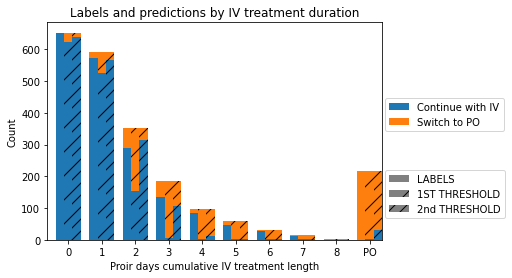

In [15]:
plot_clustered_stacked([df1, df2, df3],["LABELS", "1ST THRESHOLD", "2nd THRESHOLD"], title="Labels and predictions by IV treatment duration",  H="/")

Treatment day 2

In [4]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')

# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag', 'iv_treatment_length'] + shap_list
hold_out_data = hold_out_data[shap_list]

###
# Need to run native filtered_test_data through iv_treatment_length_fun as some errors 
hold_out_data = iv_treatment_length_fun(hold_out_data)
###

individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

stays = hold_out_data['stay_id'].unique()
random.Random(22).shuffle(stays) # Best split from CV

X_data = hold_out_data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag', 'iv_treatment_length'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
model_data = pd.concat([hold_out_data[['stay_id', 'po_flag', 'iv_treatment_length']], X_data], axis=1)
model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.7 * len(stays))
n2 = round(0.85 * len(stays))
train_stays = stays[:n]
validation_stays = stays[n:n2]
test_stays = stays[n2:]
train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
test_data = model_data2[model_data2['stay_id'].isin(test_stays)]

14303


In [5]:
# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

model.load_state_dict(torch.load('hold_out_switch_model_short.pt'))

# Define batch size 
batch_size = 256

# Define loss
criterion = nn.BCEWithLogitsLoss()

<All keys matched successfully>

In [6]:
treatment_length_df = pd.DataFrame()

for i in test_data.iv_treatment_length.unique():
    print(i)
    temp_test_data = test_data[test_data['iv_treatment_length'] == i]
    temp_test_data = temp_test_data.drop(columns=['iv_treatment_length'])

    temp_test_dataset = MIMICDataset(temp_test_data)
    temp_test_dataloader = DataLoader(dataset=temp_test_dataset, batch_size=batch_size, collate_fn=temp_test_dataset.collate_fn_padd)

    test_loss, test_accuracy, test_auroc, test_predictions, test_labels = evaluate(model, temp_test_dataloader, criterion)

    # Use new cut off
    lower_bound_test_predictions, upper_bound_test_predictions = new_threshold_fun(test_predictions)

    print(np.unique(test_labels, return_counts=True))
    print(np.unique(lower_bound_test_predictions, return_counts=True))
    print(np.unique(upper_bound_test_predictions, return_counts=True))

    label_values, label_counts = np.unique(test_labels, return_counts=True)
    lower_bound_values, lower_bound_counts =np.unique(lower_bound_test_predictions, return_counts=True)
    upper_bound_values, upper_bound_counts =np.unique(upper_bound_test_predictions, return_counts=True)

    label_0 = 0
    label_1 = 0
    for x in range(len(label_values)):
        if label_values[x] == 0:
            label_0 = label_counts[x]
        elif label_values[x] == 1:
            label_1 = label_counts[x]
    prediction_0 = 0
    prediction_1 = 0
    for x in range(len(lower_bound_values)):
        if lower_bound_values[x] == 0:
            prediction_0 = lower_bound_counts[x]
        elif lower_bound_values[x] == 1:
            prediction_1 = lower_bound_counts[x]
    ub_prediction_0 = 0
    ub_prediction_1 = 0
    for x in range(len(upper_bound_values)):
        if upper_bound_values[x] == 0:
            ub_prediction_0 = upper_bound_counts[x]
        elif upper_bound_values[x] == 1:
            ub_prediction_1 = upper_bound_counts[x]

    # Lower bound
    try:
        test_auroc2 = roc_auc_score(test_labels, lower_bound_test_predictions)
    except:
        test_auroc2 = np.nan
    #print('Test AUROC result 2:', test_auroc2)
    test_accuracy2 = accuracy_score(test_labels, lower_bound_test_predictions)
    #assert test_accuracy == test_accuracy2
    test_balanced_accuracy = balanced_accuracy_score(test_labels, lower_bound_test_predictions)
    test_recall = recall_score(test_labels, lower_bound_test_predictions)
    test_precision = precision_score(test_labels, lower_bound_test_predictions)
    test_f1 = f1_score(test_labels, lower_bound_test_predictions)
    test_auprc = average_precision_score(test_labels, lower_bound_test_predictions)
    test_cm = confusion_matrix(test_labels, lower_bound_test_predictions)
    if test_cm.shape == (2, 2):
        tn, fp, fn, tp = test_cm.ravel()
        test_true_positive_rate = (tp / (tp + fn))
        test_false_positive_rate = (fp / (fp + tn))
    else:
        test_true_positive_rate = np.nan
        test_false_positive_rate = np.nan

    # Upper bound
    try:
        ub_test_auroc2 = roc_auc_score(test_labels, upper_bound_test_predictions)
    except:
        ub_test_auroc2 = np.nan
    #print('Test ub_AUROC result 2:', ub_test_auroc2)
    ub_test_accuracy2 = accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_balanced_accuracy = balanced_accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_recall = recall_score(test_labels, upper_bound_test_predictions)
    ub_test_precision = precision_score(test_labels, upper_bound_test_predictions)
    ub_test_f1 = f1_score(test_labels, upper_bound_test_predictions)
    ub_test_auprc = average_precision_score(test_labels, upper_bound_test_predictions)
    ub_test_cm = confusion_matrix(test_labels, upper_bound_test_predictions)
    if ub_test_cm.shape == (2, 2):
        tn, fp, fn, tp = ub_test_cm.ravel()
        ub_test_true_positive_rate = (tp / (tp + fn))
        ub_test_false_positive_rate = (fp / (fp + tn))
    else:
        ub_test_true_positive_rate = np.nan
        ub_test_false_positive_rate = np.nan
    
    sub_df = pd.DataFrame([[i, label_0, label_1, prediction_0, prediction_1, test_auroc2, test_balanced_accuracy, test_accuracy2, test_recall, test_precision, test_f1, test_auprc, test_cm, test_true_positive_rate, test_false_positive_rate, ub_prediction_0, ub_prediction_1, ub_test_auroc2, ub_test_balanced_accuracy, ub_test_accuracy2, ub_test_recall, ub_test_precision, ub_test_f1, ub_test_auprc, ub_test_cm, ub_test_true_positive_rate, ub_test_false_positive_rate]])
    treatment_length_df = pd.concat([treatment_length_df, sub_df], axis=0, ignore_index=True)
treatment_length_df.columns = ['iv_treatment_length', 'label_0', 'label_1', 'prediction_0', 'prediction_1', 'auroc', 'balanced_accuracy', 'accuracy', 'recall', 'precision', 'f1', 'auprc', 'cm', 'tpr', 'fpr', 'ub_prediction_0', 'ub_prediction_1','ub_auroc', 'ub_balanced_accuracy', 'ub_accuracy', 'ub_recall', 'ub_precision', 'ub_f1', 'ub_auprc', 'ub_cm', 'ub_tpr', 'ub_fpr']
treatment_length_df.sort_values(by=['iv_treatment_length'], inplace=True)
# Set to string
treatment_length_df['iv_treatment_length']= treatment_length_df['iv_treatment_length'].astype(str)
# Change 999
treatment_length_df['iv_treatment_length'] = treatment_length_df['iv_treatment_length'].replace(['999'], 'PO')
# Rename
treatment_length_df.rename(columns={'iv_treatment_length': 'Proir days cumulative IV treatment length', 'label_0': 'Continue with IV', 'label_1': 'Switch to PO'}, inplace=True)

0


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
y_pred contains classes not in y_true
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide
invalid value encountered in long_scalars
y_pred contains classes not in y_true
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide
invalid value encountered in long_scalars


(array([0.], dtype=float32), array([652]))
(array([0, 1]), array([623,  29]))
(array([0, 1]), array([637,  15]))
1


100%|██████████| 3/3 [00:00<00:00,  5.92it/s]


(array([0., 1.], dtype=float32), array([573,  19]))
(array([0, 1]), array([526,  66]))
(array([0, 1]), array([567,  25]))
2


100%|██████████| 2/2 [00:00<00:00,  6.57it/s]


(array([0., 1.], dtype=float32), array([289,  67]))
(array([0, 1]), array([154, 202]))
(array([0, 1]), array([317,  39]))
3


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


(array([0., 1.], dtype=float32), array([135,  52]))
(array([0, 1]), array([  6, 181]))
(array([0, 1]), array([108,  79]))
4


100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


(array([0., 1.], dtype=float32), array([84, 16]))
(array([0, 1]), array([ 3, 97]))
(array([0, 1]), array([13, 87]))
5


100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


(array([0., 1.], dtype=float32), array([48, 13]))
(array([0, 1]), array([ 1, 60]))
(array([0, 1]), array([ 2, 59]))
6


100%|██████████| 1/1 [00:00<00:00, 33.57it/s]


(array([0., 1.], dtype=float32), array([28,  6]))
(array([0, 1]), array([ 1, 33]))
(array([0, 1]), array([ 1, 33]))
999


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


(array([0., 1.], dtype=float32), array([  1, 203]))
(array([0, 1]), array([  2, 202]))
(array([0, 1]), array([ 26, 178]))
7


100%|██████████| 1/1 [00:00<00:00, 62.58it/s]


(array([0., 1.], dtype=float32), array([13,  4]))
(array([0, 1]), array([ 1, 16]))
(array([0, 1]), array([ 1, 16]))
8


100%|██████████| 1/1 [00:00<00:00, 285.42it/s]

(array([1.], dtype=float32), array([3]))
(array([1]), array([3]))
(array([1]), array([3]))


In [7]:
treatment_length_df

,Proir days cumulative IV treatment length,Continue with IV,Switch to PO,prediction_0,prediction_1,auroc,balanced_accuracy,accuracy,...,ub_accuracy,ub_recall,ub_precision,ub_f1,ub_auprc,ub_cm,ub_tpr,ub_fpr
0,0,652,0,623,29,NaN,0.955521,0.955521,...,0.976994,0.000000,0.000000,0.000000,NaN,"[[637, 15], [0, 0]]",NaN,0.023006
1,1,573,19,526,66,0.523974,0.523974,0.866554,...,0.932432,0.105263,0.080000,0.090909,0.037137,"[[550, 23], [17, 2]]",0.105263,0.040140
2,2,289,67,154,202,0.591773,0.591773,0.514045,...,0.764045,0.164179,0.282051,0.207547,0.203610,"[[261, 28], [56, 11]]",0.164179,0.096886
3,3,135,52,6,181,0.495584,0.495584,0.288770,...,0.502674,0.365385,0.240506,0.290076,0.264348,"[[75, 60], [33, 19]]",0.365385,0.444444
4,4,84,16,3,97,0.517857,0.517857,0.190000,...,0.270000,0.937500,0.172414,0.291262,0.171638,"[[12, 72], [1, 15]]",0.937500,0.857143
5,5,48,13,1,60,0.510417,0.510417,0.229508,...,0.245902,1.000000,0.220339,0.361111,0.220339,"[[2, 46], [0, 13]]",1.000000,0.958333
6,6,28,6,1,33,0.517857,0.517857,0.205882,...,0.205882,1.000000,0.181818,0.307692,0.181818,"[[1, 27], [0, 6]]",1.000000,0.964286
8,7,13,4,1,16,0.375000,0.375000,0.176471,...,0.176471,0.750000,0.187500,0.300000,0.199449,"[[0, 13], [1, 3]]",0.750000,1.000000
9,8,0,3,0,3,NaN,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,[[3]],NaN,NaN
7,PO,1,203,2,202,0.495074,0.495074,0.985294,...,0.877451,0.876847,1.000000,0.934383,0.999396,"[[1, 0], [25, 178]]",0.876847,0.000000


In [8]:
df1 = treatment_length_df[['Proir days cumulative IV treatment length', 'Continue with IV', 'Switch to PO']].set_index(['Proir days cumulative IV treatment length'])
df2 = treatment_length_df[['Proir days cumulative IV treatment length', 'prediction_0', 'prediction_1']].set_index(['Proir days cumulative IV treatment length'])
df3 = treatment_length_df[['Proir days cumulative IV treatment length', 'ub_prediction_0', 'ub_prediction_1']].set_index(['Proir days cumulative IV treatment length'])

<AxesSubplot:title={'center':'Labels and predictions by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Count'>

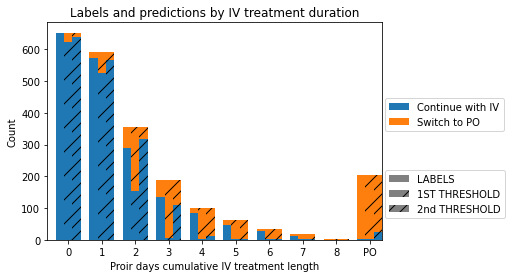

In [9]:
plot_clustered_stacked([df1, df2, df3],["LABELS", "1ST THRESHOLD", "2nd THRESHOLD"], title="Labels and predictions by IV treatment duration",  H="/")

### Antibiotic spectrum

In [2]:
mimic_data = pd.read_csv('mimic_data.csv')

In [3]:
mimic_data

,stay_id,date,iv_flag,first_po_flag,po_flag,iv_treatment_length,blood pressure diastolic0,blood pressure diastolic1,...,temperature16_current_stay_difference,temperature17_current_stay_difference,temperature18_current_stay_difference,temperature19_current_stay_difference,temperature20_current_stay_difference,temperature21_current_stay_difference,temperature_mean_current_stay_difference,temperature_std_current_stay_difference
0,30000646.0,2194-04-29,1.0,NaN,0,0,0.421875,0.470626,...,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.000000
1,30000646.0,2194-04-30,1.0,NaN,0,1,0.596354,0.542931,...,0.171429,-1.000000,-1.0,-1.0,0.531196,0.4,0.558757,0.244600
2,30000646.0,2194-05-01,1.0,NaN,0,2,0.622396,0.576501,...,0.385714,0.674183,-1.0,-1.0,0.622217,0.4,0.728050,0.602105
3,30000646.0,2194-05-02,1.0,NaN,0,3,0.476563,0.486120,...,0.385714,0.674183,-1.0,-1.0,0.622217,0.4,0.728050,0.602105
4,30000646.0,2194-05-03,1.0,1.0,0,4,0.438802,0.435119,...,0.385714,0.674183,-1.0,-1.0,0.622217,0.1,0.410176,0.455833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28818,39996073.0,2175-09-14,NaN,1.0,1,1,0.941406,0.907682,...,0.742857,0.484462,-1.0,-1.0,0.412870,0.8,0.548080,0.408792
28819,39996073.0,2175-09-15,NaN,1.0,1,999,0.989583,0.943189,...,0.742857,0.484462,-1.0,-1.0,0.412870,0.8,0.548080,0.408792
28820,39996073.0,2175-09-16,NaN,1.0,1,999,0.980469,0.994190,...,0.600000,0.484462,-1.0,-1.0,0.722340,0.4,0.842413,0.581162
28821,39996073.0,2175-09-17,NaN,1.0,1,999,0.980469,0.994190,...,0.600000,0.484462,-1.0,-1.0,0.722340,0.4,0.842413,0.581162


In [8]:
mimic_data = pd.read_csv('mimic_data.csv')
antibiotics_df, antibiotics_value_counts = specific_antibiotics(mimic_data)
antibiotics_df = calculate_asi(antibiotics_df)

Mean iv_asi: 8.245245901639345
STD iv_asi: 2.8163701756686086
Mean po_asi: 5.888524590163934
STD po_asi: 2.5915075797010823
Mean % ASI change: -23.035806634167216
STD % ASI change: 41.320415614145084
Percentage who decrease ASI: 70.0327868852459
Mean iv_asi for those who decrease: 9.00561797752809
STD iv_asi for those who decrease: 2.6181484497099667
Mean po_asi for those who decrease: 5.317415730337078
STD po_asi for those who decrease: 2.516933479461367
Mean % ASI change for those who decrease: -41.317439842720724
STD % ASI change for those who decrease: 20.42237169799019


In [9]:
antibiotics_df

,stay_id,iv_antibiotics,po_antibiotics,iv_asi,po_asi,%_change_asi,decrease_asi
0,30003226.0,CefazoLIN_IV,Sulfameth/Trimethoprim SS_PO,3,4,33.333333,False
1,30004823.0,"Azithromycin _IV,Azithromycin_PO,Sulfameth/Tri...","Azithromycin_PO,Sulfameth/Trimethoprim DS_PO",6,6,0.000000,False
2,30008792.0,"Doxycycline Hyclate_PO,Vancomycin_IV",Doxycycline Hyclate_PO,8,5,-37.500000,True
3,30046600.0,Vancomycin_IV,Nitrofurantoin Monohyd (MacroBID)_PO,5,0,-100.000000,True
4,30048944.0,CeFAZolin_IV,Sulfameth/Trimethoprim DS_PO,3,4,33.333333,False
...,...,...,...,...,...,...,...
1520,39968384.0,"Levofloxacin_PO,Vancomycin_IV",Levofloxacin_PO,11,9,-18.181818,True
1521,39983109.0,"CefTAZidime_IV,LevoFLOXacin_PO,Vancomycin_IV",LevoFLOXacin_PO,12,9,-25.000000,True
1522,39989059.0,"Levofloxacin_PO,Vancomycin_IV",Levofloxacin_PO,11,9,-18.181818,True
1523,39991309.0,"CeFAZolin_IV,Ciprofloxacin HCl_PO,Vancomycin_IV",Ciprofloxacin HCl_PO,11,8,-27.272727,True


In [11]:
from scipy.stats import shapiro
print('Not Gaussian' if shapiro(antibiotics_df['iv_asi'])[1]<0.05 else 'Gaussian')
print('Not Gaussian' if shapiro(antibiotics_df['po_asi'])[1]<0.05 else 'Gaussian')

Not Gaussian
Not Gaussian


(array([ 16.,  75.,  69., 293., 160., 151., 343., 232.,  99.,  87.]),
 array([ 1. ,  2.3,  3.6,  4.9,  6.2,  7.5,  8.8, 10.1, 11.4, 12.7, 14. ]),
 <BarContainer object of 10 artists>)

(array([ 31., 121., 483., 148., 131., 282., 234.,  88.,   4.,   3.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

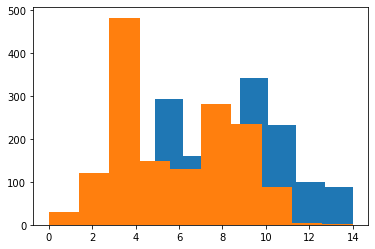

In [13]:
plt.hist(antibiotics_df['iv_asi'])
plt.hist(antibiotics_df['po_asi'])

In [14]:
test_stats(antibiotics_df['iv_asi'], antibiotics_df['po_asi'])

3.399035028406605e-104
Different distribution


In [9]:
# Mean iv_asi
Mean_iv_asi = antibiotics_df['iv_asi'].mean()
STD_iv_asi = antibiotics_df['iv_asi'].std()
# Mean po_asi
Mean_po_asi = antibiotics_df['po_asi'].mean()
STD_po_asi = antibiotics_df['po_asi'].std()
# Mean % ASI change
Mean_percentage_ASI_change = antibiotics_df['%_change_asi'].mean()
STD_percentage_ASI_change = antibiotics_df['%_change_asi'].std()
# Percentage decreasing ASI
Percentage_of_patients_who_decrease_ASI = (len(antibiotics_df[antibiotics_df['decrease_asi'] == True])/len(antibiotics_df))*100

In [10]:
# Create lists for the plot
names = ['Mean IV \n ASI', 'Mean oral \n ASI', 'Mean ASI \n decrease', 'Patients who \n decrease']
x_pos = np.arange(len(names))
asi_means = [Mean_iv_asi, Mean_po_asi, np.nan, np.nan]
percentage_means = [np.nan, np.nan, abs(Mean_percentage_ASI_change), Percentage_of_patients_who_decrease_ASI]
asi_error = [STD_iv_asi, STD_po_asi,np.nan,np.nan]
percentage_error = [np.nan, np.nan, STD_percentage_ASI_change, np.nan]

[Text(0, 0, 'Mean IV \n ASI'),
 Text(1, 0, 'Mean oral \n ASI'),
 Text(2, 0, 'Mean ASI \n decrease'),
 Text(3, 0, 'Patients who \n decrease')]

Text(0, 0.5, 'ASI')

Text(0, 0.5, 'Percentage')

Text(0.5, 1.0, 'MIMIC dataset antibiotic spectrum index (ASI) results')

(0.0, 14.0)

(0.0, 100.0)

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

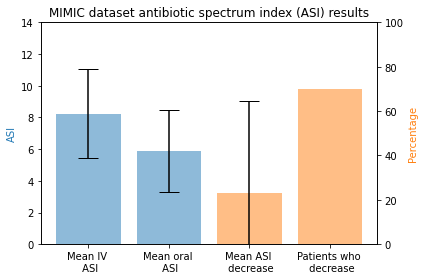

In [13]:
# Build the plot
fig, ax = plt.subplots()

color = 'tab:blue'
color2 = 'tab:orange'

par1 = ax.twinx()
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_ylabel('ASI', color=color)
par1.set_ylabel("Percentage", color=color2)
ax.set_title('MIMIC dataset antibiotic spectrum index (ASI) results')

ax.set_ylim(0, 14)
par1.set_ylim(0, 100)

ax.bar(x_pos, asi_means, yerr=asi_error, color=color, align='center', alpha=0.5, ecolor='black', capsize=10)
par1.bar(x_pos, percentage_means, yerr=percentage_error, color=color2, align='center', alpha=0.5, ecolor='black', capsize=10)

# Save the figure and show
plt.tight_layout()
plt.show()

### Bad bioavailability

In [3]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

data_dict, random_x_list = data_fun(hold_out_data, individual, n_cv=10)

# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

model.apply(init_weights)

Model_simplex_short(
  (layers): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [21]:
# Define antibiotics with bad bioavailability
pattern = 'Azithromycin|Ciprofloxacin|Cefpodoxime|Clindamycin|Amoxicillin|Clarithromycin|Nitrofurantoin|Ampicillin|Erythromycin|Penicillin|DiCLOXacillin|Tetracycline|Neomycin|Augmentin|flucloxacillin'

In [4]:
antibiotics_df, antibiotics_value_counts = specific_antibiotics(hold_out_data)
antibiotics_df
antibiotics_value_counts

,stay_id,iv_antibiotics,po_antibiotics
0,39212926.0,"CefTRIAXone_IV,Cefpodoxime Proxetil_PO",Cefpodoxime Proxetil_PO
1,36566205.0,"Gentamicin_IV,Rifampin_PO",Rifampin_PO
2,34926077.0,"Clindamycin_IV,Clindamycin_PO",Clindamycin_PO
3,30760029.0,"CefePIME_IV,Levofloxacin_IV,Vancomycin_IV",Levofloxacin_PO
4,36753859.0,"Azithromycin_PO,CefTRIAXone_IV",Azithromycin_PO
...,...,...,...
766,33618765.0,CefazoLIN_IV,Ciprofloxacin HCl_PO
767,37496175.0,"Linezolid_PO,Meropenem_IV",Linezolid_PO
768,36673129.0,"Meropenem_IV,Sulfameth/Trimethoprim DS_PO",Sulfameth/Trimethoprim DS_PO
769,31901852.0,"Ciprofloxacin HCl_PO,Ciprofloxacin IV_IV,Metro...","Ciprofloxacin HCl_PO,MetroNIDAZOLE_PO"


iv_antibiotics                                                                                                        po_antibiotics                                                   
Ciprofloxacin HCl_PO,Ciprofloxacin IV_IV                                                                              Ciprofloxacin HCl_PO                                                 21
Ciprofloxacin HCl_PO,Vancomycin_IV                                                                                    Ciprofloxacin HCl_PO                                                 15
Levofloxacin_IV,Levofloxacin_PO                                                                                       Levofloxacin_PO                                                      13
Piperacillin-Tazobactam_IV,Sulfameth/Trimethoprim SS_PO,Sulfameth/Trimethoprim Suspension_PO,Vancomycin_IV            Sulfameth/Trimethoprim SS_PO,Sulfameth/Trimethoprim Suspension_PO    12
Vancomycin_IV                                           

In [22]:
antibiotics_df, antibiotics_value_counts = specific_antibiotics(hold_out_data)
# Filter for those patients with bad bioavailability drugs
filtered_antibiotics_df = antibiotics_df[antibiotics_df['po_antibiotics'].str.contains(pattern, case=False, na=False)]
# Define stay list
bad_bio_stay_id_list = filtered_antibiotics_df.stay_id.unique()

In [23]:
# Run bad bio short model cv
test_results, ub_test_results, mean_equalised_odds_df, sd_equalised_odds_df = bad_bio_run_fun(data_dict, model, 'short', bad_bio_stay_id_list)

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Test AUROC result: 0.7628446115288222
Test AUROC result 2: 0.768483709273183


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


Test AUROC result: 0.7031009244992296
Test AUROC result 2: 0.7158127889060092


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Test AUROC result: 0.72153143936413
Test AUROC result 2: 0.7251514913040056


100%|██████████| 2/2 [00:00<00:00,  8.18it/s]


Test AUROC result: 0.7071877252600144
Test AUROC result 2: 0.7300226547214499


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


Test AUROC result: 0.7614570431257742
Test AUROC result 2: 0.7694516383290169


100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


Test AUROC result: 0.6940928270042194
Test AUROC result 2: 0.6926493448811903


100%|██████████| 2/2 [00:00<00:00,  8.28it/s]


Test AUROC result: 0.7621434477056634
Test AUROC result 2: 0.7373914840843324


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


Test AUROC result: 0.7275371687136393
Test AUROC result 2: 0.718164188752424


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Test AUROC result: 0.7541345831938399
Test AUROC result 2: 0.769969869434215


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Test AUROC result: 0.7023473870565865
Test AUROC result 2: 0.6957904399711494


100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


In [24]:
# Save 
with open("bad_bio_short_test_results", "wb") as fp:   #Pickling
    pickle.dump(test_results, fp)
with open("bad_bio_short_ub_test_results", "wb") as fp:   #Pickling
    pickle.dump(ub_test_results, fp)

In [25]:
analyze_results_fun(test_results)

mean test_auroc: 0.7322887609656975
std test_auroc: 0.027509098948783433
test_auroc 2.5th percentile: 0.6933560912764312
test_auroc 97.5th percentile: 0.7698532674355454
mean test_accuracy: 0.7232004699990979
std test_accuracy: 0.02844431100802479
test_accuracy 2.5th percentile: 0.6871407381722916
test_accuracy 97.5th percentile: 0.7666600212652844
mean test_balanced_accuracy: 0.7322887609656977
std test_balanced_accuracy: 0.02750909894878344
test_balanced_accuracy 2.5th percentile: 0.6933560912764312
test_balanced_accuracy 97.5th percentile: 0.7698532674355454
mean test_recall: 0.790515713670705
std test_recall: 0.05824099942822805
test_recall 2.5th percentile: 0.69682604336383
test_recall 97.5th percentile: 0.8901561120917917
mean test_precision: 0.6393107626136766
std test_precision: 0.03768016613458795
test_precision 2.5th percentile: 0.5867508162313433
test_precision 97.5th percentile: 0.7036767968056789
mean test_f1: 0.7054486329240272
std test_f1: 0.03309040846335226
test_f1 2.5

In [26]:
analyze_results_fun(ub_test_results)

mean test_auroc: 0.6748840887193486
std test_auroc: 0.05118566601028954
test_auroc 2.5th percentile: 0.5719997438684538
test_auroc 97.5th percentile: 0.7170342394455093
mean test_accuracy: 0.7075285563091163
std test_accuracy: 0.03994113255001116
test_accuracy 2.5th percentile: 0.6272350240887192
test_accuracy 97.5th percentile: 0.7420670628183361
mean test_balanced_accuracy: 0.6748840887193485
std test_balanced_accuracy: 0.0511856660102895
test_balanced_accuracy 2.5th percentile: 0.5719997438684539
test_balanced_accuracy 97.5th percentile: 0.7170342394455093
mean test_recall: 0.46985244476596966
std test_recall: 0.12476055222718192
test_recall 2.5th percentile: 0.21501696463526035
test_recall 97.5th percentile: 0.6098776223776224
mean test_precision: 0.738841239841065
std test_precision: 0.06153742997434301
test_precision 2.5th percentile: 0.6415178571428571
test_precision 97.5th percentile: 0.8368695652173913
mean test_f1: 0.5640894630632565
std test_f1: 0.11169959359846283
test_f1 2

In [27]:
mean_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.833333,0.833333,0.800000,0.133333
"(anchor_age, 30)",0.847619,0.847619,0.857143,0.161905
"(anchor_age, 40)",0.676257,0.676257,0.593915,0.241402
"(anchor_age, 50)",0.740823,0.740823,0.815314,0.333669
"(anchor_age, 60)",0.707587,0.707587,0.781359,0.366185
"(anchor_age, 70)",0.719710,0.719710,0.729688,0.290269
"(anchor_age, 80)",0.764350,0.764350,0.850957,0.322257
"(anchor_age, 90)",0.738479,0.738479,0.701504,0.224547
"(gender, F)",0.743738,0.743738,0.793434,0.305959
"(gender, M)",0.723631,0.723631,0.787636,0.340374


In [28]:
sd_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.212459,0.212459,0.447214,0.217307
"(anchor_age, 30)",0.180388,0.180388,0.377964,0.203150
"(anchor_age, 40)",0.179504,0.179504,0.320460,0.334237
"(anchor_age, 50)",0.059545,0.059545,0.154499,0.155617
"(anchor_age, 60)",0.050130,0.050130,0.117970,0.122687
"(anchor_age, 70)",0.049527,0.049527,0.189355,0.193843
"(anchor_age, 80)",0.055900,0.055900,0.079492,0.138397
"(anchor_age, 90)",0.116334,0.116334,0.268356,0.166958
"(gender, F)",0.041735,0.041735,0.062608,0.099929
"(gender, M)",0.045147,0.045147,0.069439,0.072339


### eICU

In [3]:
eicu_data = pd.read_csv('eicu_data.csv')
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
eicu_data2 = eicu_data[shap_list]

individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

stays = eicu_data2['stay_id'].unique()
X_data = eicu_data2.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
eicu_data3 = pd.concat([eicu_data2[['stay_id', 'po_flag']], X_data], axis=1)

In [32]:
# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

model.load_state_dict(torch.load('hold_out_switch_model_short.pt'))

# Define dataloader and batch size 
batch_size = 256

eicu_dataset = MIMICDataset(eicu_data3)
eicu_dataloader = DataLoader(dataset=eicu_dataset, batch_size=batch_size, collate_fn=eicu_dataset.collate_fn_padd)

# Define loss
criterion = nn.BCEWithLogitsLoss()

test_loss, test_accuracy, test_auroc, test_predictions, test_labels = evaluate(model, eicu_dataloader, criterion)

# Use new cut off
lower_bound_test_predictions, upper_bound_test_predictions = new_threshold_fun(test_predictions)

# Lower bound
print('lb_auroc', roc_auc_score(test_labels, lower_bound_test_predictions))
print('lb_accuracy', accuracy_score(test_labels, lower_bound_test_predictions))
print('lb_balanced_accuracy', balanced_accuracy_score(test_labels, lower_bound_test_predictions))
print('lb_recall', recall_score(test_labels, lower_bound_test_predictions))
print('lb_precision', precision_score(test_labels, lower_bound_test_predictions))
print('lb_f1', f1_score(test_labels, lower_bound_test_predictions))
print('lb_auprc', average_precision_score(test_labels, lower_bound_test_predictions))
lb_cm = confusion_matrix(test_labels, lower_bound_test_predictions)
print('lb_cm', lb_cm)
tn, fp, fn, tp = lb_cm.ravel()
print('lb_tpr', (tp / (tp + fn)))
print('lb_fpr', (fp / (fp + tn)))

# Upper bound
print('ub_auroc', roc_auc_score(test_labels, upper_bound_test_predictions))
print('ub_accuracy', accuracy_score(test_labels, upper_bound_test_predictions))
print('ub_balanced_accuracy', balanced_accuracy_score(test_labels, upper_bound_test_predictions))
print('ub_recall', recall_score(test_labels, upper_bound_test_predictions))
print('ub_precision', precision_score(test_labels, upper_bound_test_predictions))
print('ub_f1', f1_score(test_labels, upper_bound_test_predictions))
print('ub_auprc', average_precision_score(test_labels, upper_bound_test_predictions))
ub_cm = confusion_matrix(test_labels, upper_bound_test_predictions)
print('ub_cm', ub_cm)
tn, fp, fn, tp = ub_cm.ravel()
print('ub_tpr', (tp / (tp + fn)))
print('ub_tpr', (fp / (fp + tn)))

<All keys matched successfully>

100%|██████████| 20/20 [00:04<00:00,  4.62it/s]

lb_auroc 0.585021048674405
lb_accuracy 0.5985445724681625
lb_balanced_accuracy 0.5850210486744049
lb_recall 0.5645933014354066
lb_precision 0.22540592168099333
lb_f1 0.32218430034129697
lb_auprc 0.20084262092785743
lb_cm [[2489 1622]
 [ 364  472]]
lb_tpr 0.5645933014354066
lb_fpr 0.39455120408659694
ub_auroc 0.5085608805410622
ub_accuracy 0.7913887204366282
ub_balanced_accuracy 0.5085608805410621
ub_recall 0.08133971291866028
ub_precision 0.20481927710843373
ub_f1 0.11643835616438357
ub_auprc 0.1719055445962051
ub_cm [[3847  264]
 [ 768   68]]
ub_tpr 0.08133971291866028
ub_tpr 0.06421795183653613


In [4]:
# Split eICU
eicu_data_dict, eicu_random_x_list = data_fun(eicu_data2, individual, n_cv=10)
eicu_random_x_list

# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

model.apply(init_weights)

[3, 12, 22, 26, 64, 68, 86, 90, 97, 105]

Model_simplex_short(
  (layers): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [34]:
# Run short model cv
test_results, ub_test_results = eicu_run_fun(eicu_data_dict, model, 'short')

100%|██████████| 3/3 [00:00<00:00,  4.77it/s]


Test AUROC result: 0.7441839781462423
Test AUROC result 2: 0.735213772949622
UPDATED BEST OVERALL MODEL


100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Test AUROC result: 0.6903342235384331
Test AUROC result 2: 0.681396916893625


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Test AUROC result: 0.7207800887558146
Test AUROC result 2: 0.7259129551408865


100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


Test AUROC result: 0.7496998928188638
Test AUROC result 2: 0.7620900321543409
UPDATED BEST OVERALL MODEL


100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


Test AUROC result: 0.7287284556788103
Test AUROC result 2: 0.7199591844981917


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Test AUROC result: 0.7284188293313929
Test AUROC result 2: 0.7402730616864742


100%|██████████| 3/3 [00:00<00:00,  4.85it/s]


Test AUROC result: 0.6921296296296295
Test AUROC result 2: 0.7049074074074074


100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


Test AUROC result: 0.7460817717206133
Test AUROC result 2: 0.7176630013938362


100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Test AUROC result: 0.7311848461734045
Test AUROC result 2: 0.7321595050428003


100%|██████████| 3/3 [00:00<00:00,  4.77it/s]


Test AUROC result: 0.6866524913744685
Test AUROC result 2: 0.6794846077723394


In [35]:
# Save 
with open("eicu_short_test_results", "wb") as fp:   #Pickling
    pickle.dump(test_results, fp)
with open("eicu_short_ub_test_results", "wb") as fp:   #Pickling
    pickle.dump(ub_test_results, fp)

In [36]:
analyze_results_fun(test_results)

mean test_auroc: 0.7199060444939525
std test_auroc: 0.024416592025726675
test_auroc 2.5th percentile: 0.6799148773246287
test_auroc 97.5th percentile: 0.7571812137990709
mean test_accuracy: 0.7464032235323477
std test_accuracy: 0.028254950753925773
test_accuracy 2.5th percentile: 0.6950350036845984
test_accuracy 97.5th percentile: 0.7870753373251176
mean test_balanced_accuracy: 0.7199060444939522
std test_balanced_accuracy: 0.024416592025726675
test_balanced_accuracy 2.5th percentile: 0.6799148773246286
test_balanced_accuracy 97.5th percentile: 0.7571812137990708
mean test_recall: 0.6820126179572966
std test_recall: 0.06305675127562074
test_recall 2.5th percentile: 0.6046074380165289
test_recall 97.5th percentile: 0.8000833333333334
mean test_precision: 0.3556721002796023
std test_precision: 0.04721246620312974
test_precision 2.5th percentile: 0.28858296035805625
test_precision 97.5th percentile: 0.4137301861636462
mean test_f1: 0.46565359100655046
std test_f1: 0.04851537418356824
test

In [37]:
analyze_results_fun(ub_test_results)

mean test_auroc: 0.6481290446034559
std test_auroc: 0.04602567353715142
test_auroc 2.5th percentile: 0.5577284357454956
test_auroc 97.5th percentile: 0.6956764789437753
mean test_accuracy: 0.8525403329282399
std test_accuracy: 0.016314163371525442
test_accuracy 2.5th percentile: 0.8285988398348673
test_accuracy 97.5th percentile: 0.881505136422175
mean test_balanced_accuracy: 0.6481290446034559
std test_balanced_accuracy: 0.04602567353715141
test_balanced_accuracy 2.5th percentile: 0.5577284357454957
test_balanced_accuracy 97.5th percentile: 0.6956764789437753
mean test_recall: 0.3437679210581381
std test_recall: 0.10418529386519661
test_recall 2.5th percentile: 0.13150673400673402
test_recall 97.5th percentile: 0.4522782651072125
mean test_precision: 0.5966021175367533
std test_precision: 0.11521951948736961
test_precision 2.5th percentile: 0.4767729342875732
test_precision 97.5th percentile: 0.8190140845070423
mean test_f1: 0.4199276289291725
std test_f1: 0.10288205344896521
test_f1 

In [38]:
# Get base rate of auprc
test_data_pr_ratio_list = []
for key, value in eicu_data_dict.items():
        train_data = value[0]
        valid_data = value[1]
        test_data = value[2]
        test_data_pr_ratio_list.append(test_data.po_flag.value_counts(normalize=True)[1])
np.array(test_data_pr_ratio_list).mean()

0.16302460172477629

Distribution

In [3]:
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

eicu_data = pd.read_csv('eicu_data.csv')

In [4]:
# Group mimic
grouped_mimic = hold_out_data.groupby('iv_treatment_length').po_flag.value_counts()
grouped_mimic2 = pd.pivot(pd.DataFrame(grouped_mimic).rename(columns={'po_flag': 'count'}).reset_index(level=1), columns=['po_flag'])
grouped_mimic2 = grouped_mimic2.droplevel('po_flag', axis=1)
grouped_mimic2.reset_index(inplace=True)
grouped_mimic2.columns = ['iv_treatment_length', 'label_0', 'label_1']
# Set to string
grouped_mimic2['iv_treatment_length']= grouped_mimic2['iv_treatment_length'].astype(str)
# Change 999
grouped_mimic2['iv_treatment_length'] = grouped_mimic2['iv_treatment_length'].replace(['999'], 'PO')
grouped_mimic2.rename(columns={'iv_treatment_length': 'Proir days cumulative IV treatment length'}, inplace=True)
# Change to %
grouped_mimic2.fillna(0, inplace=True)
grouped_mimic2['Continue with IV'] = grouped_mimic2['label_0']/(grouped_mimic2['label_0']+grouped_mimic2['label_1'])*100
grouped_mimic2['Switch to PO'] = grouped_mimic2['label_1']/(grouped_mimic2['label_0']+grouped_mimic2['label_1'])*100

In [5]:
# Group eicu
grouped_eicu = eicu_data.groupby('iv_treatment_length').po_flag.value_counts()
grouped_eicu2 = pd.pivot(pd.DataFrame(grouped_eicu).rename(columns={'po_flag': 'count'}).reset_index(level=1), columns=['po_flag'])
grouped_eicu2 = grouped_eicu2.droplevel('po_flag', axis=1)
grouped_eicu2.reset_index(inplace=True)
grouped_eicu2.columns = ['iv_treatment_length', 'label_0', 'label_1']
# Set to string
grouped_eicu2['iv_treatment_length']= grouped_eicu2['iv_treatment_length'].astype(str)
# Change 999
grouped_eicu2['iv_treatment_length'] = grouped_eicu2['iv_treatment_length'].replace(['999'], 'PO')
grouped_eicu2.rename(columns={'iv_treatment_length': 'Proir days cumulative IV treatment length'}, inplace=True)
# Change to %
grouped_eicu2.fillna(0, inplace=True)
grouped_eicu2['Continue with IV'] = grouped_eicu2['label_0']/(grouped_eicu2['label_0']+grouped_eicu2['label_1'])*100
grouped_eicu2['Switch to PO'] = grouped_eicu2['label_1']/(grouped_eicu2['label_0']+grouped_eicu2['label_1'])*100

In [6]:
df1 = grouped_mimic2[['Proir days cumulative IV treatment length', 'Continue with IV', 'Switch to PO']].set_index(['Proir days cumulative IV treatment length'])
df2 = grouped_eicu2[['Proir days cumulative IV treatment length', 'Continue with IV', 'Switch to PO']].set_index(['Proir days cumulative IV treatment length'])

<AxesSubplot:title={'center':'MIMIC and eICU labels by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Percentage'>

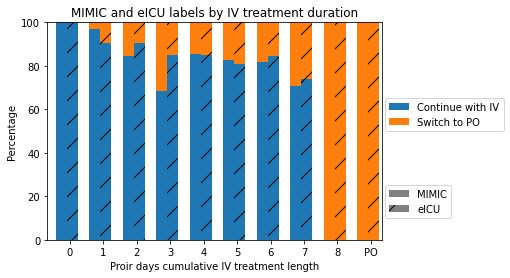

In [7]:
plot_clustered_stacked_2([df1, df2],["MIMIC", "eICU"], title="MIMIC and eICU labels by IV treatment duration",  H="/", )

<AxesSubplot:title={'center':'MIMIC and eICU labels by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Count'>

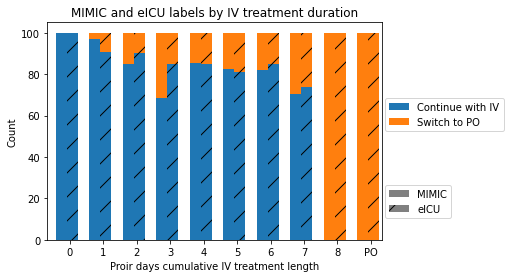

In [43]:
plot_clustered_stacked([df1, df2],["MIMIC", "eICU"], title="MIMIC and eICU labels by IV treatment duration",  H="/", )

In [44]:
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag', 'iv_treatment_length'] + shap_list
eicu_data = eicu_data[shap_list]

individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

X_data = eicu_data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag', 'iv_treatment_length'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
eicu_model_data = pd.concat([eicu_data[['stay_id', 'po_flag', 'iv_treatment_length']], X_data], axis=1)

<All keys matched successfully>

0


100%|██████████| 7/7 [00:01<00:00,  4.77it/s]
y_pred contains classes not in y_true
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide
invalid value encountered in long_scalars
y_pred contains classes not in y_true
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide
invalid value encountered in long_scalars


(array([0.], dtype=float32), array([1633]))
(array([0, 1]), array([1560,   73]))
(array([0, 1]), array([1625,    8]))
1


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


(array([0., 1.], dtype=float32), array([1161,  121]))
(array([0, 1]), array([1159,  123]))
(array([0, 1]), array([1269,   13]))
999


100%|██████████| 3/3 [00:00<00:00,  6.33it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
y_pred contains classes not in y_true
invalid value encountered in long_scalars


(array([1.], dtype=float32), array([515]))
(array([0, 1]), array([ 96, 419]))
(array([0, 1]), array([355, 160]))
2


100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


(array([0., 1.], dtype=float32), array([665,  71]))
(array([0, 1]), array([375, 361]))
(array([0, 1]), array([723,  13]))
3


100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


(array([0., 1.], dtype=float32), array([329,  58]))
(array([0, 1]), array([ 31, 356]))
(array([0, 1]), array([380,   7]))
4


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


(array([0., 1.], dtype=float32), array([171,  30]))
(array([0, 1]), array([  3, 198]))
(array([0, 1]), array([191,  10]))
5


100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


(array([0., 1.], dtype=float32), array([85, 20]))
(array([0, 1]), array([  1, 104]))
(array([0, 1]), array([94, 11]))
6


100%|██████████| 1/1 [00:00<00:00, 16.79it/s]


(array([0., 1.], dtype=float32), array([50,  9]))
(array([1]), array([59]))
(array([0, 1]), array([41, 18]))
7


100%|██████████| 1/1 [00:00<00:00, 42.35it/s]


(array([0., 1.], dtype=float32), array([17,  6]))
(array([1]), array([23]))
(array([0, 1]), array([ 7, 16]))
8


100%|██████████| 1/1 [00:00<00:00, 147.80it/s]

(array([1.], dtype=float32), array([6]))
(array([1]), array([6]))
(array([1]), array([6]))


<AxesSubplot:title={'center':'eICU Labels and predictions by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Count'>

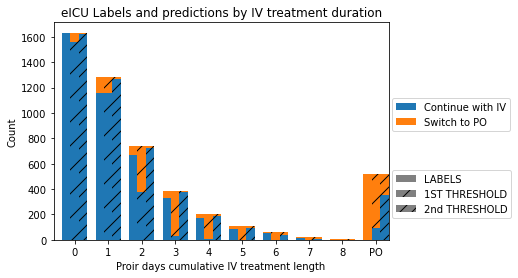

In [101]:
model.load_state_dict(torch.load('eicu_switch_model_short.pt'))
treatment_length_df = pd.DataFrame()

for i in eicu_model_data.iv_treatment_length.unique():
    print(i)
    temp_test_data = eicu_model_data[eicu_model_data['iv_treatment_length'] == i]
    temp_test_data = temp_test_data.drop(columns=['iv_treatment_length'])

    temp_test_dataset = MIMICDataset(temp_test_data)
    temp_test_dataloader = DataLoader(dataset=temp_test_dataset, batch_size=batch_size, collate_fn=temp_test_dataset.collate_fn_padd)

    test_loss, test_accuracy, test_auroc, test_predictions, test_labels = evaluate(model, temp_test_dataloader, criterion)

    # Use new cut off
    lower_bound_test_predictions, upper_bound_test_predictions = new_threshold_fun(test_predictions)

    print(np.unique(test_labels, return_counts=True))
    print(np.unique(lower_bound_test_predictions, return_counts=True))
    print(np.unique(upper_bound_test_predictions, return_counts=True))

    label_values, label_counts = np.unique(test_labels, return_counts=True)
    lower_bound_values, lower_bound_counts =np.unique(lower_bound_test_predictions, return_counts=True)
    upper_bound_values, upper_bound_counts =np.unique(upper_bound_test_predictions, return_counts=True)

    label_0 = 0
    label_1 = 0
    for x in range(len(label_values)):
        if label_values[x] == 0:
            label_0 = label_counts[x]
        elif label_values[x] == 1:
            label_1 = label_counts[x]
    prediction_0 = 0
    prediction_1 = 0
    for x in range(len(lower_bound_values)):
        if lower_bound_values[x] == 0:
            prediction_0 = lower_bound_counts[x]
        elif lower_bound_values[x] == 1:
            prediction_1 = lower_bound_counts[x]
    ub_prediction_0 = 0
    ub_prediction_1 = 0
    for x in range(len(upper_bound_values)):
        if upper_bound_values[x] == 0:
            ub_prediction_0 = upper_bound_counts[x]
        elif upper_bound_values[x] == 1:
            ub_prediction_1 = upper_bound_counts[x]

    # Lower bound
    try:
        test_auroc2 = roc_auc_score(test_labels, lower_bound_test_predictions)
    except:
        test_auroc2 = np.nan
    #print('Test AUROC result 2:', test_auroc2)
    test_accuracy2 = accuracy_score(test_labels, lower_bound_test_predictions)
    #assert test_accuracy == test_accuracy2
    test_balanced_accuracy = balanced_accuracy_score(test_labels, lower_bound_test_predictions)
    test_recall = recall_score(test_labels, lower_bound_test_predictions)
    test_precision = precision_score(test_labels, lower_bound_test_predictions)
    test_f1 = f1_score(test_labels, lower_bound_test_predictions)
    test_auprc = average_precision_score(test_labels, lower_bound_test_predictions)
    test_cm = confusion_matrix(test_labels, lower_bound_test_predictions)
    if test_cm.shape == (2, 2):
        tn, fp, fn, tp = test_cm.ravel()
        test_true_positive_rate = (tp / (tp + fn))
        test_false_positive_rate = (fp / (fp + tn))
    else:
        test_true_positive_rate = np.nan
        test_false_positive_rate = np.nan

    # Upper bound
    try:
        ub_test_auroc2 = roc_auc_score(test_labels, upper_bound_test_predictions)
    except:
        ub_test_auroc2 = np.nan
    #print('Test ub_AUROC result 2:', ub_test_auroc2)
    ub_test_accuracy2 = accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_balanced_accuracy = balanced_accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_recall = recall_score(test_labels, upper_bound_test_predictions)
    ub_test_precision = precision_score(test_labels, upper_bound_test_predictions)
    ub_test_f1 = f1_score(test_labels, upper_bound_test_predictions)
    ub_test_auprc = average_precision_score(test_labels, upper_bound_test_predictions)
    ub_test_cm = confusion_matrix(test_labels, upper_bound_test_predictions)
    if ub_test_cm.shape == (2, 2):
        tn, fp, fn, tp = ub_test_cm.ravel()
        ub_test_true_positive_rate = (tp / (tp + fn))
        ub_test_false_positive_rate = (fp / (fp + tn))
    else:
        ub_test_true_positive_rate = np.nan
        ub_test_false_positive_rate = np.nan
    
    sub_df = pd.DataFrame([[i, label_0, label_1, prediction_0, prediction_1, test_auroc2, test_balanced_accuracy, test_accuracy2, test_recall, test_precision, test_f1, test_auprc, test_cm, test_true_positive_rate, test_false_positive_rate, ub_prediction_0, ub_prediction_1, ub_test_auroc2, ub_test_balanced_accuracy, ub_test_accuracy2, ub_test_recall, ub_test_precision, ub_test_f1, ub_test_auprc, ub_test_cm, ub_test_true_positive_rate, ub_test_false_positive_rate]])
    treatment_length_df = pd.concat([treatment_length_df, sub_df], axis=0, ignore_index=True)
treatment_length_df.columns = ['iv_treatment_length', 'label_0', 'label_1', 'prediction_0', 'prediction_1', 'auroc', 'balanced_accuracy', 'accuracy', 'recall', 'precision', 'f1', 'auprc', 'cm', 'tpr', 'fpr', 'ub_prediction_0', 'ub_prediction_1','ub_auroc', 'ub_balanced_accuracy', 'ub_accuracy', 'ub_recall', 'ub_precision', 'ub_f1', 'ub_auprc', 'ub_cm', 'ub_tpr', 'ub_fpr']
treatment_length_df.sort_values(by=['iv_treatment_length'], inplace=True)
# Set to string
treatment_length_df['iv_treatment_length']= treatment_length_df['iv_treatment_length'].astype(str)
# Change 999
treatment_length_df['iv_treatment_length'] = treatment_length_df['iv_treatment_length'].replace(['999'], 'PO')
# Rename
treatment_length_df.rename(columns={'iv_treatment_length': 'Proir days cumulative IV treatment length', 'label_0': 'Continue with IV', 'label_1': 'Switch to PO'}, inplace=True)
# Get dfs
df1 = treatment_length_df[['Proir days cumulative IV treatment length', 'Continue with IV', 'Switch to PO']].set_index(['Proir days cumulative IV treatment length'])
df2 = treatment_length_df[['Proir days cumulative IV treatment length', 'prediction_0', 'prediction_1']].set_index(['Proir days cumulative IV treatment length'])
df3 = treatment_length_df[['Proir days cumulative IV treatment length', 'ub_prediction_0', 'ub_prediction_1']].set_index(['Proir days cumulative IV treatment length'])
# Plot
plot_clustered_stacked([df1, df2, df3],["LABELS", "1ST THRESHOLD", "2nd THRESHOLD"], title="eICU Labels and predictions by IV treatment duration",  H="/")

### Bad absorption

In [50]:
# Look at results in those with bad absorption
# 225916 = TPN w/ Lipids
# 225917 = TPN without Lipids

In [51]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)

In [52]:
# First look at other iv input events in icu
stays = hold_out_data['stay_id'].unique()
inputevents = pd.read_csv('mimic-iv-2.0/icu/inputevents.csv')
inputevents = inputevents[inputevents['stay_id'].isin(stays)]
inputevents = inputevents[['stay_id', 'itemid', 'starttime', 'endtime']]
inputevents['starttime'] = pd.to_datetime(inputevents['starttime']).dt.date
inputevents['endtime'] = pd.to_datetime(inputevents['endtime']).dt.date
# Filter for TPN
inputevents = inputevents[(inputevents['itemid'] == 225916)|(inputevents['itemid'] == 225917)]
inputevents.drop_duplicates(inplace=True)

In [53]:
dates = inputevents.copy()
dates['date'] = dates.apply(lambda x:
    pd.date_range(start=x['starttime'],
                end=x['endtime'],
                #inclusive='both',
                freq='D'), axis=1)
dates = dates.explode('date')
dates['date'] = dates['date'].astype(str)
dates['TPN'] = 1
dates = dates[['stay_id', 'date', 'TPN']]
new_hold_out_data = pd.merge(hold_out_data[['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag']], dates, how='left')#, on=['stay_id', 'date'])
new_hold_out_data.drop_duplicates(inplace=True)
# Get list of stays
tpn_stay_list = new_hold_out_data[new_hold_out_data['TPN'] == 1].stay_id.unique().tolist()
# Filter data
#filtered_new_hold_out_data = new_hold_out_data[new_hold_out_data['stay_id'].isin(tpn_stay_list)]

In [54]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')

# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

data_dict, random_x_list = bad_abs_data_fun(tpn_stay_list, hold_out_data, individual, n_cv=10)
random_x_list

# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

model.apply(init_weights)

[2, 7, 15, 22, 35, 36, 43, 47, 48, 50]

Model_simplex_short(
  (layers): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [55]:
# Run bad bio short model cv
test_results, ub_test_results, mean_equalised_odds_df, sd_equalised_odds_df = bad_abs_run_fun(data_dict, model, 'short', tpn_stay_list)

100%|██████████| 1/1 [00:00<00:00, 53.09it/s]


Test AUROC result: 0.6666666666666667
Test AUROC result 2: 0.7


100%|██████████| 1/1 [00:00<00:00, 136.30it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 395.39it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 96.19it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 168.23it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 165.58it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 147.46it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 147.80it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 170.41it/s]
y_pred contains classes not in y_true
invalid value encountered i

Test AUROC result: 0.7333333333333334
Test AUROC result 2: 0.7333333333333334


100%|██████████| 1/1 [00:00<00:00, 102.93it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 148.35it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 109.08it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 29.13it/s]


Test AUROC result: 0.7115384615384616
Test AUROC result 2: 0.7307692307692308


100%|██████████| 1/1 [00:00<00:00, 104.26it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 146.42it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 99.55it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 167.16it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 53.82it/s]


Test AUROC result: 0.7
Test AUROC result 2: 0.7


100%|██████████| 1/1 [00:00<00:00, 55.21it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 144.05it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 107.20it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 144.89it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 108.73it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 148.28it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 69.42it/s]


Test AUROC result: 0.9
Test AUROC result 2: 0.9


100%|██████████| 1/1 [00:00<00:00, 178.11it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 176.28it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 197.06it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 43.57it/s]


Test AUROC result: 0.782608695652174
Test AUROC result 2: 0.8043478260869565


100%|██████████| 1/1 [00:00<00:00, 81.34it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 104.95it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 84.97it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 84.79it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 240.60it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 172.67it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 169.49it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 229.32it/s]


Test AUROC result: 0.6666666666666667
Test AUROC result 2: 0.6666666666666667


100%|██████████| 1/1 [00:00<00:00, 42.95it/s]


Test AUROC result: 0.7142857142857143
Test AUROC result 2: 0.7142857142857143


100%|██████████| 1/1 [00:00<00:00, 140.51it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 147.22it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 104.33it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 128.34it/s]
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Test AUROC result: 0.9285714285714286
Test AUROC result 2: 1.0


100%|██████████| 1/1 [00:00<00:00, 223.92it/s]


Test AUROC result: 0.6666666666666667
Test AUROC result 2: 0.6666666666666667


100%|██████████| 1/1 [00:00<00:00, 225.10it/s]


In [56]:
# Save 
with open("bad_abs_short_test_results", "wb") as fp:   #Pickling
    pickle.dump(test_results, fp)
with open("bad_abs_short_ub_test_results", "wb") as fp:   #Pickling
    pickle.dump(ub_test_results, fp)

In [57]:
analyze_results_fun(test_results)

mean test_auroc: 0.7616069437808568
std test_auroc: 0.10364288403793756
test_auroc 2.5th percentile: 0.6666666666666667
test_auroc 97.5th percentile: 0.9775
mean test_accuracy: 0.6353671328671329
std test_accuracy: 0.16847238507908943
test_accuracy 2.5th percentile: 0.4446428571428571
test_accuracy 97.5th percentile: 0.971875
mean test_balanced_accuracy: 0.7616069437808568
std test_balanced_accuracy: 0.10364288403793759
test_balanced_accuracy 2.5th percentile: 0.6666666666666666
test_balanced_accuracy 97.5th percentile: 0.9775
mean test_recall: 1.0
std test_recall: 0.0
test_recall 2.5th percentile: 1.0
test_recall 97.5th percentile: 1
mean test_precision: 0.44043740573152335
std test_precision: 0.2505137254522368
test_precision 2.5th percentile: 0.11586538461538462
test_precision 97.5th percentile: 0.9437500000000001
mean test_f1: 0.5729004329004329
std test_f1: 0.22704587317643962
test_f1 2.5th percentile: 0.20071428571428573
test_f1 97.5th percentile: 0.9678571428571429
mean test_aup

In [58]:
analyze_results_fun(ub_test_results)

mean test_auroc: 0.7526616499442587
std test_auroc: 0.11495715900942867
test_auroc 2.5th percentile: 0.52625
test_auroc 97.5th percentile: 0.8614130434782609
mean test_accuracy: 0.7329816017316018
std test_accuracy: 0.062054664581494556
test_accuracy 2.5th percentile: 0.6431818181818182
test_accuracy 97.5th percentile: 0.8512019230769231
mean test_balanced_accuracy: 0.7526616499442587
std test_balanced_accuracy: 0.11495715900942866
test_balanced_accuracy 2.5th percentile: 0.52625
test_balanced_accuracy 97.5th percentile: 0.8614130434782609
mean test_recall: 0.7833333333333333
std test_recall: 0.3320468371191274
test_recall 2.5th percentile: 0.075
test_recall 97.5th percentile: 1
mean test_precision: 0.4107323232323233
std test_precision: 0.1969389787624179
test_precision 2.5th percentile: 0.028125
test_precision 97.5th percentile: 0.6541666666666667
mean test_f1: 0.499795751633987
std test_f1: 0.214384693161789
test_f1 2.5th percentile: 0.049999999999999996
test_f1 97.5th percentile: 0

In [59]:
# Get base rate of auprc
test_data_pr_ratio_list = []
for key, value in data_dict.items():
        train_data = value[0]
        valid_data = value[1]
        test_data = value[2]
        # Filter for bad bio
        test_data = test_data[test_data['stay_id'].isin(tpn_stay_list)]
        if len(test_data.po_flag.value_counts(normalize=True)) == 2:
                test_data_pr_ratio_list.append(test_data.po_flag.value_counts(normalize=True)[1])
        else:
                test_data_pr_ratio_list.append(0.0)
np.array(test_data_pr_ratio_list).mean()

0.23092074592074593

In [60]:
mean_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 30)",1.000000,NaN,NaN,NaN
"(anchor_age, 40)",0.675000,0.750000,1.0,0.450000
"(anchor_age, 50)",0.547619,0.642857,1.0,0.857143
"(anchor_age, 60)",1.000000,1.000000,1.0,0.000000
"(anchor_age, 70)",0.794940,0.821825,1.0,0.387075
"(anchor_age, 80)",0.546997,0.655714,1.0,0.668182
"(gender, F)",0.785769,0.785769,1.0,0.428462
"(gender, M)",0.550420,0.705882,1.0,0.555822
"(grouped_race, ASIAN)",0.700000,0.700000,1.0,0.600000
"(grouped_race, BLACK)",0.750000,0.750000,1.0,0.500000


In [61]:
sd_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 30)",0.000000,NaN,NaN,NaN
"(anchor_age, 40)",0.106066,NaN,NaN,0.070711
"(anchor_age, 50)",0.506757,NaN,NaN,0.202031
"(anchor_age, 60)",NaN,NaN,NaN,NaN
"(anchor_age, 70)",0.201912,0.144753,0.0,0.276501
"(anchor_age, 80)",0.184069,0.031569,0.0,0.117763
"(gender, F)",0.124216,0.124216,0.0,0.248433
"(gender, M)",0.228584,NaN,NaN,0.115236
"(grouped_race, ASIAN)",NaN,NaN,NaN,NaN
"(grouped_race, BLACK)",0.089753,0.089753,0.0,0.179505


### Type of infection

In [62]:
# Look at results in different types of infections 

In [65]:
# Import diagnosis
diagnoses_icd = pd.read_csv(r"mimic-iv-2.0/hosp/diagnoses_icd.csv")
d_icd_diagnoses = pd.read_csv(r"mimic-iv-2.0/hosp/d_icd_diagnoses.csv")

# Filter by uti
uti_d_icd_diagnoses = d_icd_diagnoses[(d_icd_diagnoses['long_title'].str.contains("urinary tract infection", case=False)) | \
                                  (d_icd_diagnoses['long_title'].str.contains("pyelonephritis", case=False))]

# Filter by pneumonia
pneumonia_d_icd_diagnoses = d_icd_diagnoses[d_icd_diagnoses['long_title'].str.contains("pneumonia", case=False)]

# Filter by spesfic sepsis
sepsis_d_icd_diagnoses = d_icd_diagnoses[(d_icd_diagnoses['icd_code'] == 'A410')| \
                                    (d_icd_diagnoses['icd_code'] == 'A4101')| \
                                    (d_icd_diagnoses['icd_code'] == 'A4102')| \
                                    (d_icd_diagnoses['icd_code'] == 'A411')| \
                                    (d_icd_diagnoses['icd_code'] == 'A412')| \
                                    (d_icd_diagnoses['icd_code'] == 'A4181')| \
                                    (d_icd_diagnoses['icd_code'] == 'P362')| \
                                    (d_icd_diagnoses['icd_code'] == 'P363')| \
                                    (d_icd_diagnoses['icd_code'] == 'P3630')| \
                                    (d_icd_diagnoses['icd_code'] == 'P3639')]
#diagnoses_icd = pd.merge(diagnoses_icd, d_icd_diagnoses, how='inner', on='icd_code')

In [66]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')

# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
import random
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)

In [67]:
# Get subject_id and hadm_id
icu_stays = pd.read_csv(r"mimic-iv-2.0/icu/icustays.csv")

hold_out_stays = hold_out_data.stay_id.unique().tolist()

icu_stays = icu_stays[icu_stays['stay_id'].isin(hold_out_stays)]

In [68]:
diagnoses = pd.merge(diagnoses_icd, icu_stays[['subject_id', 'hadm_id', 'stay_id']])
uti_diagnoses = pd.merge(diagnoses, uti_d_icd_diagnoses)
pneumonia_diagnoses = pd.merge(diagnoses, pneumonia_d_icd_diagnoses)
sepsis_diagnoses = pd.merge(diagnoses, sepsis_d_icd_diagnoses)

In [69]:
uti_stays = uti_diagnoses.stay_id.unique().tolist()
pneumonia_stays = pneumonia_diagnoses.stay_id.unique().tolist()
sepsis_stays = sepsis_diagnoses.stay_id.unique().tolist()

In [70]:
len(uti_stays)
len(pneumonia_stays)
len(sepsis_stays)

691

1158

43

UTI

In [71]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

data_dict, random_x_list = data_fun(hold_out_data, individual, n_cv=10)
random_x_list

# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

model.apply(init_weights)

[2, 3, 7, 8, 15, 17, 18, 22, 25, 33]

Model_simplex_short(
  (layers): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [72]:
# Run short model cv
test_results, ub_test_results, mean_equalised_odds_df, sd_equalised_odds_df = diagnosis_run_fun(data_dict, model, 'short', uti_stays)

100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Test AUROC result: 0.7852112676056339
Test AUROC result 2: 0.7922535211267606


100%|██████████| 1/1 [00:00<00:00, 221.37it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 276.52it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 224.21it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Test AUROC result: 0.762843169488739
Test AUROC result 2: 0.7537604800263029


100%|██████████| 1/1 [00:00<00:00, 225.17it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 102.06it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


Test AUROC result: 0.7602432778489115
Test AUROC result 2: 0.7519606274007682


100%|██████████| 1/1 [00:00<00:00, 189.99it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Test AUROC result: 0.7938492063492063
Test AUROC result 2: 0.8152777777777778


100%|██████████| 1/1 [00:00<00:00, 177.23it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Test AUROC result: 0.7965584415584416
Test AUROC result 2: 0.7311688311688312


100%|██████████| 1/1 [00:00<00:00, 219.91it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 55.52it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


Test AUROC result: 0.7355428796223445
Test AUROC result 2: 0.7392309205350118


100%|██████████| 1/1 [00:00<00:00, 180.60it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


Test AUROC result: 0.7848910098273142
Test AUROC result 2: 0.7913414486189185


100%|██████████| 1/1 [00:00<00:00, 96.25it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 57.26it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Test AUROC result: 0.7736382322713258
Test AUROC result 2: 0.7719681397738951


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Test AUROC result: 0.7773159988633134
Test AUROC result 2: 0.7985578289286729


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Test AUROC result: 0.7385559717020391
Test AUROC result 2: 0.7540054099042862


100%|██████████| 1/1 [00:00<00:00, 69.13it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 57.99it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 101.37it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 40.32it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 127.67it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  7.92it/s]


In [73]:
# Save 
with open("uti_short_test_results", "wb") as fp:   #Pickling
    pickle.dump(test_results, fp)
with open("uti_short_ub_test_results", "wb") as fp:   #Pickling
    pickle.dump(ub_test_results, fp)

In [74]:
analyze_results_fun(test_results)

mean test_auroc: 0.7699524985261225
std test_auroc: 0.0266828000865222
test_auroc 2.5th percentile: 0.7329828012762218
test_auroc 97.5th percentile: 0.8115157892867292
mean test_accuracy: 0.7105118096391718
std test_accuracy: 0.027575321499504795
test_accuracy 2.5th percentile: 0.6689906590555268
test_accuracy 97.5th percentile: 0.7460763566790353
mean test_balanced_accuracy: 0.7699524985261226
std test_balanced_accuracy: 0.02668280008652222
test_balanced_accuracy 2.5th percentile: 0.7329828012762218
test_balanced_accuracy 97.5th percentile: 0.8115157892867292
mean test_recall: 0.8661313800423788
std test_recall: 0.04747827830159944
test_recall 2.5th percentile: 0.78
test_recall 97.5th percentile: 0.9290609903381642
mean test_precision: 0.37872673348920416
std test_precision: 0.06859531737192741
test_precision 2.5th percentile: 0.2694602272727273
test_precision 97.5th percentile: 0.4559155181671738
mean test_f1: 0.5243589060730811
std test_f1: 0.07438039636157942
test_f1 2.5th percenti

In [75]:
analyze_results_fun(ub_test_results)

mean test_auroc: 0.7373627797693167
std test_auroc: 0.042180081468992464
test_auroc 2.5th percentile: 0.6913400088028169
test_auroc 97.5th percentile: 0.8040351134585288
mean test_accuracy: 0.8094838257918842
std test_accuracy: 0.021391922306265996
test_accuracy 2.5th percentile: 0.7807758388357364
test_accuracy 97.5th percentile: 0.8411191023207805
mean test_balanced_accuracy: 0.737362779769317
std test_balanced_accuracy: 0.042180081468992464
test_balanced_accuracy 2.5th percentile: 0.6913400088028169
test_balanced_accuracy 97.5th percentile: 0.804035113458529
mean test_recall: 0.6263961085905053
std test_recall: 0.09625550827674496
test_recall 2.5th percentile: 0.4772112676056338
test_recall 97.5th percentile: 0.7607638888888889
mean test_precision: 0.4874223568741948
std test_precision: 0.08169458084399821
test_precision 2.5th percentile: 0.3311824729891957
test_precision 97.5th percentile: 0.5767250468603562
mean test_f1: 0.5448730116067246
std test_f1: 0.08189431353629982
test_f1 

In [76]:
mean_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.856250,0.800000,1.000000,0.310000
"(anchor_age, 30)",0.726232,0.500000,0.000000,0.245489
"(anchor_age, 40)",0.904330,0.861518,1.000000,0.251772
"(anchor_age, 50)",0.787852,0.787852,0.879004,0.303300
"(anchor_age, 60)",0.778663,0.778663,0.891328,0.334001
"(anchor_age, 70)",0.686005,0.686005,0.732489,0.360479
"(anchor_age, 80)",0.766775,0.766775,0.843182,0.309633
"(anchor_age, 90)",0.785913,0.785913,0.887459,0.315633
"(gender, F)",0.763123,0.763123,0.848328,0.322082
"(gender, M)",0.778587,0.778587,0.885226,0.328052


In [77]:
sd_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.120823,0.000000,0.000000,0.082158
"(anchor_age, 30)",0.156276,NaN,NaN,0.140305
"(anchor_age, 40)",0.100827,0.067154,0.000000,0.121162
"(anchor_age, 50)",0.071316,0.071316,0.141268,0.105491
"(anchor_age, 60)",0.052677,0.052677,0.068591,0.056138
"(anchor_age, 70)",0.108711,0.108711,0.235908,0.062453
"(anchor_age, 80)",0.050975,0.050975,0.132006,0.041115
"(anchor_age, 90)",0.099301,0.099301,0.205544,0.126135
"(gender, F)",0.040865,0.040865,0.084005,0.038955
"(gender, M)",0.046422,0.046422,0.044765,0.075348


Pneumonia

In [78]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

data_dict, random_x_list = data_fun(hold_out_data, individual, n_cv=10)
random_x_list

# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

model.apply(init_weights)

[2, 3, 7, 8, 15, 17, 18, 22, 25, 33]

Model_simplex_short(
  (layers): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [79]:
# Run bad bio short model cv
test_results, ub_test_results, mean_equalised_odds_df, sd_equalised_odds_df = diagnosis_run_fun(data_dict, model, 'short', pneumonia_stays)

100%|██████████| 3/3 [00:00<00:00,  5.98it/s]


Test AUROC result: 0.740935943472721
Test AUROC result 2: 0.7502142939881848


100%|██████████| 1/1 [00:00<00:00, 90.26it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 28.09it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  5.75it/s]


Test AUROC result: 0.79086127547666
Test AUROC result 2: 0.7939184746877055


100%|██████████| 1/1 [00:00<00:00, 240.60it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 60.16it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  6.12it/s]


Test AUROC result: 0.7398956975228161
Test AUROC result 2: 0.7601948428219615


100%|██████████| 1/1 [00:00<00:00, 84.74it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 25.50it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 65.19it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 213.35it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  5.42it/s]


Test AUROC result: 0.7492732558139534
Test AUROC result 2: 0.77640503875969


100%|██████████| 1/1 [00:00<00:00, 185.71it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 73.63it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 50.40it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 156.95it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 50.20it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  4.85it/s]


Test AUROC result: 0.7478712923542451
Test AUROC result 2: 0.754626860420112


100%|██████████| 1/1 [00:00<00:00, 73.29it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  5.97it/s]


Test AUROC result: 0.6688860583603521
Test AUROC result 2: 0.6669947506561679


100%|██████████| 1/1 [00:00<00:00, 75.27it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 36.44it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 23.79it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 29.98it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 51.59it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 119.40it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 23.04it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  5.29it/s]


Test AUROC result: 0.7821031048623317
Test AUROC result 2: 0.7794961921499707


100%|██████████| 1/1 [00:00<00:00, 103.88it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 40.25it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 52.21it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  4.86it/s]


Test AUROC result: 0.7367701547839599
Test AUROC result 2: 0.7489242813601864


100%|██████████| 1/1 [00:00<00:00, 118.01it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


Test AUROC result: 0.7753859534681453
Test AUROC result 2: 0.7834311806914547


100%|██████████| 1/1 [00:00<00:00, 37.43it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 39.65it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 3/3 [00:00<00:00,  5.97it/s]


Test AUROC result: 0.727912087912088
Test AUROC result 2: 0.7364102564102566


100%|██████████| 1/1 [00:00<00:00, 224.09it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


In [80]:
# Save 
with open("pneumonia_short_test_results", "wb") as fp:   #Pickling
    pickle.dump(test_results, fp)
with open("pneumonia_short_ub_test_results", "wb") as fp:   #Pickling
    pickle.dump(ub_test_results, fp)

In [81]:
analyze_results_fun(test_results)

mean test_auroc: 0.755061617194569
std test_auroc: 0.03399797978969972
test_auroc 2.5th percentile: 0.6826132394508378
test_auroc 97.5th percentile: 0.7915588335385491
mean test_accuracy: 0.6795453044275593
std test_accuracy: 0.025099606000414477
test_accuracy 2.5th percentile: 0.6418591483845721
test_accuracy 97.5th percentile: 0.7261411222780569
mean test_balanced_accuracy: 0.755061617194569
std test_balanced_accuracy: 0.033997979789699706
test_balanced_accuracy 2.5th percentile: 0.6826132394508378
test_balanced_accuracy 97.5th percentile: 0.7915588335385491
mean test_recall: 0.8601093477442422
std test_recall: 0.07055645227361093
test_recall 2.5th percentile: 0.7062734082397003
test_recall 97.5th percentile: 0.9289367816091955
mean test_precision: 0.27723795028143766
std test_precision: 0.05164790990014591
test_precision 2.5th percentile: 0.17910574450964614
test_precision 97.5th percentile: 0.3444812241327097
mean test_f1: 0.41776321406062894
std test_f1: 0.0657407754346109
test_f1

In [82]:
analyze_results_fun(ub_test_results)

mean test_auroc: 0.7626497801541124
std test_auroc: 0.029499382876300575
test_auroc 2.5th percentile: 0.718655684661753
test_auroc 97.5th percentile: 0.8186620794377116
mean test_accuracy: 0.8231116671550197
std test_accuracy: 0.0226435475577603
test_accuracy 2.5th percentile: 0.7833166999334664
test_accuracy 97.5th percentile: 0.8603367912909808
mean test_balanced_accuracy: 0.7626497801541124
std test_balanced_accuracy: 0.029499382876300564
test_balanced_accuracy 2.5th percentile: 0.7186556846617531
test_balanced_accuracy 97.5th percentile: 0.8186620794377116
mean test_recall: 0.6804312983673262
std test_recall: 0.06519976637337323
test_recall 2.5th percentile: 0.580341446923597
test_recall 97.5th percentile: 0.8050188323917138
mean test_precision: 0.40536061402293766
std test_precision: 0.048066952571733615
test_precision 2.5th percentile: 0.3500864112186451
test_precision 97.5th percentile: 0.4866134073223626
mean test_f1: 0.505937452249335
std test_f1: 0.04411491470726039
test_f1 2

In [83]:
mean_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.617612,NaN,NaN,0.491642
"(anchor_age, 30)",0.741611,0.707338,0.750000,0.315540
"(anchor_age, 40)",0.803116,0.829453,0.986111,0.322210
"(anchor_age, 50)",0.739834,0.739834,0.832937,0.353268
"(anchor_age, 60)",0.740945,0.740945,0.838047,0.356157
"(anchor_age, 70)",0.740303,0.740303,0.836162,0.355555
"(anchor_age, 80)",0.735893,0.735893,0.808923,0.337136
"(anchor_age, 90)",0.714096,0.714096,0.770714,0.342522
"(gender, F)",0.753782,0.753782,0.853999,0.346435
"(gender, M)",0.750668,0.750668,0.852342,0.351006


In [84]:
sd_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 20)",0.270679,NaN,NaN,0.187146
"(anchor_age, 30)",0.171061,0.187857,0.418330,0.091579
"(anchor_age, 40)",0.074726,0.056542,0.039284,0.090179
"(anchor_age, 50)",0.096515,0.096515,0.207402,0.081242
"(anchor_age, 60)",0.074321,0.074321,0.157420,0.051204
"(anchor_age, 70)",0.091334,0.091334,0.163035,0.057549
"(anchor_age, 80)",0.103736,0.103736,0.201700,0.053785
"(anchor_age, 90)",0.091338,0.091338,0.161959,0.076874
"(gender, F)",0.040805,0.040805,0.094306,0.040558
"(gender, M)",0.048938,0.048938,0.086491,0.045456


Sepsis

In [86]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

hold_out_data.drop(columns=['iv_treatment_length'], inplace=True)
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

data_dict, random_x_list = sepsis_data_fun(sepsis_stays, hold_out_data, individual, n_cv=10)
random_x_list

# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

model.apply(init_weights)

[2, 18, 22, 25, 35, 43, 47, 48, 50, 70]

Model_simplex_short(
  (layers): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [87]:
# Run bad bio short model cv
test_results, ub_test_results, mean_equalised_odds_df, sd_equalised_odds_df = diagnosis_run_fun(data_dict, model, 'short', sepsis_stays)

100%|██████████| 1/1 [00:00<00:00, 29.99it/s]


Test AUROC result: 0.7058823529411764
Test AUROC result 2: 0.7058823529411764


100%|██████████| 1/1 [00:00<00:00, 48.79it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 55.48it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 151.16it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 185.42it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 97.21it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 96.48it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 106.61it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 37.63it/s]


Test AUROC result: 0.8125
Test AUROC result 2: 0.8125


100%|██████████| 1/1 [00:00<00:00, 80.78it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 137.98it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 98.16it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 114.91it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 102.91it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 34.09it/s]


Test AUROC result: 0.8478260869565217
Test AUROC result 2: 0.8695652173913043


100%|██████████| 1/1 [00:00<00:00, 173.26it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 77.18it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 46.98it/s]


Test AUROC result: 0.7777777777777778
Test AUROC result 2: 0.8055555555555556


100%|██████████| 1/1 [00:00<00:00, 91.31it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 352.85it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 230.95it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 389.19it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 142.45it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 36.08it/s]


Test AUROC result: 0.8043478260869565
Test AUROC result 2: 0.8260869565217391


100%|██████████| 1/1 [00:00<00:00, 167.80it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 71.55it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 63.59it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 120.38it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 79.08it/s]


Test AUROC result: 0.8125
Test AUROC result 2: 0.8125


100%|██████████| 1/1 [00:00<00:00, 181.82it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 186.55it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 30.43it/s]


Test AUROC result: 0.8125
Test AUROC result 2: 0.828125


100%|██████████| 1/1 [00:00<00:00, 54.57it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 66.42it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 112.94it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 286.05it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 41.51it/s]


Test AUROC result: 0.9090909090909091
Test AUROC result 2: 0.9090909090909091


100%|██████████| 1/1 [00:00<00:00, 172.23it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 87.97it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 39.73it/s]


Test AUROC result: 0.7916666666666666
Test AUROC result 2: 0.7916666666666666


100%|██████████| 1/1 [00:00<00:00, 180.47it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 182.71it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 99.07it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 89.40it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 33.07it/s]


Test AUROC result: 0.8636363636363636
Test AUROC result 2: 0.8636363636363636


100%|██████████| 1/1 [00:00<00:00, 126.53it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 229.20it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 92.74it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 96.47it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 287.16it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 287.66it/s]
y_pred contains classes not in y_true
invalid value encountered in long_scalars
100%|██████████| 1/1 [00:00<00:00, 46.30it/s]


In [88]:
# Save 
with open("sepsis_short_test_results", "wb") as fp:   #Pickling
    pickle.dump(test_results, fp)
with open("sepsis_short_ub_test_results", "wb") as fp:   #Pickling
    pickle.dump(ub_test_results, fp)

In [89]:
analyze_results_fun(test_results)

mean test_auroc: 0.8224609021803715
std test_auroc: 0.051465810478131466
test_auroc 2.5th percentile: 0.7251838235294117
test_auroc 97.5th percentile: 0.900197628458498
mean test_accuracy: 0.7050740335452819
std test_accuracy: 0.1054124519538404
test_accuracy 2.5th percentile: 0.48908730158730157
test_accuracy 97.5th percentile: 0.8372208436724565
mean test_balanced_accuracy: 0.8224609021803715
std test_balanced_accuracy: 0.05146581047813147
test_balanced_accuracy 2.5th percentile: 0.7251838235294117
test_balanced_accuracy 97.5th percentile: 0.900197628458498
mean test_recall: 1.0
std test_recall: 0.0
test_recall 2.5th percentile: 1.0
test_recall 97.5th percentile: 1
mean test_precision: 0.37974109224109226
std test_precision: 0.15017577910495875
test_precision 2.5th percentile: 0.13045454545454546
test_precision 97.5th percentile: 0.6129464285714286
mean test_f1: 0.5325586006700558
std test_f1: 0.1659813333952667
test_f1 2.5th percentile: 0.22390350877192985
test_f1 97.5th percentile:

In [90]:
analyze_results_fun(ub_test_results)

mean test_auroc: 0.7927074775891911
std test_auroc: 0.12391557218660887
test_auroc 2.5th percentile: 0.5604166666666667
test_auroc 97.5th percentile: 0.9494318181818181
mean test_accuracy: 0.8153779937791159
std test_accuracy: 0.07579737377154698
test_accuracy 2.5th percentile: 0.704861111111111
test_accuracy 97.5th percentile: 0.9216346153846154
mean test_balanced_accuracy: 0.7927074775891911
std test_balanced_accuracy: 0.12391557218660887
test_balanced_accuracy 2.5th percentile: 0.5604166666666667
test_balanced_accuracy 97.5th percentile: 0.9494318181818182
mean test_recall: 0.76
std test_recall: 0.2745906043549196
test_recall 2.5th percentile: 0.25
test_recall 97.5th percentile: 1
mean test_precision: 0.5286385836385836
std test_precision: 0.24609806874122467
test_precision 2.5th percentile: 0.16423076923076924
test_precision 97.5th percentile: 0.9437500000000001
mean test_f1: 0.5585742035742036
std test_f1: 0.19778975176378302
test_f1 2.5th percentile: 0.23222222222222225
test_f1 9

In [91]:
mean_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 40)",1.000000,NaN,NaN,NaN
"(anchor_age, 50)",0.578175,0.612500,1.0,0.571429
"(anchor_age, 60)",0.788297,0.821911,1.0,0.314376
"(anchor_age, 70)",0.889744,0.800000,1.0,0.430769
"(anchor_age, 80)",0.786905,0.835000,1.0,0.386111
"(gender, F)",0.761751,0.894737,1.0,0.336395
"(gender, M)",0.784265,0.804739,1.0,0.391469
"(grouped_race, ASIAN)",0.666667,NaN,NaN,0.333333
"(grouped_race, OTHER)",1.000000,NaN,NaN,NaN
"(grouped_race, UNKNOWN)",1.000000,NaN,NaN,NaN


In [92]:
sd_equalised_odds_df

,accuracy,auroc,true_positive_rate,false_positive_rate
"(anchor_age, 40)",NaN,NaN,NaN,NaN
"(anchor_age, 50)",0.266511,0.017678,0.0,0.256149
"(anchor_age, 60)",0.114686,0.029587,0.0,0.090507
"(anchor_age, 70)",0.189778,NaN,NaN,0.043514
"(anchor_age, 80)",0.212995,0.048734,0.0,0.162760
"(gender, F)",0.205992,0.148865,0.0,0.178493
"(gender, M)",0.098556,0.078814,0.0,0.148643
"(grouped_race, ASIAN)",NaN,NaN,NaN,NaN
"(grouped_race, OTHER)",0.000000,NaN,NaN,NaN
"(grouped_race, UNKNOWN)",0.000000,NaN,NaN,NaN


### LOS

In [3]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')

# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag', 'iv_treatment_length'] + shap_list
hold_out_data = hold_out_data[shap_list]

individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

stays = hold_out_data['stay_id'].unique()
import random
random.Random(22).shuffle(stays) # Best split from CV

X_data = hold_out_data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag', 'iv_treatment_length'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
model_data = pd.concat([hold_out_data[['stay_id', 'po_flag', 'date', 'iv_treatment_length']], X_data], axis=1)
model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.7 * len(stays))
n2 = round(0.85 * len(stays))
train_stays = stays[:n]
validation_stays = stays[n:n2]
test_stays = stays[n2:]
train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
test_data = model_data2[model_data2['stay_id'].isin(test_stays)]
# Filter for relevant durations
test_data = test_data[(test_data['iv_treatment_length'] >= 2) & (test_data['iv_treatment_length'] < 8)]

In [4]:
data_dict, random_x_list = los_data_fun(hold_out_data, individual, n_cv=10)
# Run
po_los_dict, iv_los_dict = los_run_fun(data_dict)

In [5]:
for i in test_data.iv_treatment_length.unique():
    print(i)
    print(mean(po_los_dict[i]))
    #print(std(po_los_dict[i]))
    print(mean(iv_los_dict[i]))
    #print(std(iv_los_dict[i]))
    test_stats(po_los_dict[i], iv_los_dict[i])

2
1.372972972972973
2.0613389414651246
1.1091252345510676e-15
Different distribution
3
1.2692307692307692
2.343283582089552
2.641947343466633e-21
Different distribution
4
1.4017094017094016
2.540136054421769
2.1621054373688337e-08
Different distribution
5
1.9801980198019802
2.48661800486618
0.17306952445278778
 Same distribution
6
1.2790697674418605
2.5148936170212766
0.08684892555061495
 Same distribution
7
2.9302325581395348
2.638095238095238
0.19486874881666516
 Same distribution


In [6]:
# See if results are same with outliers removed
for i in test_data.iv_treatment_length.unique():
    print(i)
    po_los_dict2 = reject_outliers(np.array(po_los_dict[i]))
    iv_los_dict2 = reject_outliers(np.array(iv_los_dict[i]))

    print(mean(po_los_dict2))
    #print(std(po_los_dict2))
    print(mean(iv_los_dict2))
    #print(std(iv_los_dict2))
    test_stats(po_los_dict2, iv_los_dict2)

2
1.0302457466918715
1.7042304886943838
1.1694770379993307e-18
Different distribution
3
0.9109461966604824
1.890625
2.908370600273687e-26
Different distribution
4
0.9545454545454546
2.017191977077364
5.090737414400381e-10
Different distribution
5
1.4731182795698925
1.8233766233766233
0.08955708816613912
 Same distribution
6
1.1219512195121952
1.9192825112107623
0.10299000991115334
 Same distribution
7
2.3902439024390243
1.9393939393939394
0.12622831279029897
 Same distribution


In [ ]:
labels = ['2', '3', '4', '5', '6', '7']
iv_means = [1.0302457466918715, 0.9109461966604824, 0.9545454545454546, 1.4731182795698925, 1.1219512195121952, 2.3902439024390243]
po_means = [1.7042304886943838, 1.890625, 2.017191977077364, 1.8233766233766233, 1.9192825112107623, 1.9393939393939394]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, po_means, width, label='IV')#, yerr=po_error, ecolor='black', capsize=10)
rects2 = ax.bar(x + width/2, iv_means, width, label='PO')#, yerr=iv_error, ecolor='black', capsize=10)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean remaining LOS')
ax.set_title('Remaining LOS by IV treatment duration')
ax.set_xlabel('Prior days cumulative IV treatment length')

ax.set_xticks(x, labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

### Early switch, late switch or agree

In [3]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')

# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag', 'iv_treatment_length'] + shap_list
hold_out_data = hold_out_data[shap_list]

###
# Need to run native filtered_test_data through iv_treatment_length_fun as some errors 
hold_out_data = iv_treatment_length_fun(hold_out_data)
###

individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

stays = hold_out_data['stay_id'].unique()
import random
random.Random(22).shuffle(stays) # Best split from CV

X_data = hold_out_data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag', 'iv_treatment_length'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
model_data = pd.concat([hold_out_data[['stay_id', 'po_flag', 'date', 'iv_treatment_length']], X_data], axis=1)
model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.7 * len(stays))
n2 = round(0.85 * len(stays))
train_stays = stays[:n]
validation_stays = stays[n:n2]
test_stays = stays[n2:]
train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
test_data = model_data2[model_data2['stay_id'].isin(test_stays)]


14303


In [4]:
data_dict, random_x_list = los_data_fun(hold_out_data, individual, n_cv=10)
random_x_list

# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

model.apply(init_weights)

[2, 3, 7, 8, 15, 17, 18, 22, 25, 33]

Model_simplex_short(
  (layers): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [5]:
lb_los_means, lb_mortality_means, lb_count_df2, lb_count_df3, lb_percentage_agree, lb_percentage_early, lb_percentage_late, ub_los_means, ub_mortality_means, ub_count_df2, ub_count_df3, ub_percentage_agree, ub_percentage_early, ub_percentage_late = early_late_agree_fun(data_dict, model, 'short')

100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


903
903


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


897
897


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


837
837


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


929
929


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


885
885


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


824
824


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


844
844


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


909
909


100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


843
843


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


843
843


In [8]:
lb_los_means
lb_mortality_means
lb_count_df2
lb_count_df3
lb_percentage_agree
lb_percentage_early
lb_percentage_late
ub_los_means
ub_mortality_means
ub_count_df2
ub_count_df3
ub_percentage_agree
ub_percentage_early
ub_percentage_late

,lb_los_mean
lb_difference,
-8,13.504892
-6,13.047653
-5,10.831625
-4,8.154610
-3,8.109875
-2,8.160611
-1,5.882808
0,6.351469
1,5.860873


,lb_mortality_means
lb_difference,
-7,0.000000
-6,0.500000
-5,0.000000
-4,0.166667
-3,0.428571
-2,0.111111
-1,0.038462
0,0.071429
1,0.000000


,lb_count_sum
0,17.500000
-1,20.000000
-2,10.600000
-5,3.800000
-3,7.900000
-6,3.200000
-4,5.800000
1,4.900000
-8,1.000000
-7,1.285714


,lb_count_sum
0,175.0
-1,200.0
-2,106.0
-5,38.0
-3,79.0
-6,32.0
-4,58.0
1,49.0
-8,3.0
-7,9.0


0.22860765297678992

0.7002769330461484

0.07111541397706178

,ub_los_mean
ub_difference,
-6,11.954979
-5,12.811348
-4,11.724370
-3,9.327883
-2,9.215769
-1,6.822144
0,5.973129
1,6.443774
2,6.700291


,ub_mortality_means
ub_difference,
-6,0.000000
-5,0.500000
-4,0.000000
-3,0.166667
-2,0.375000
-1,0.285714
0,0.000000
1,0.000000
2,0.100000


,ub_count_mean
1,15.800000
0,20.000000
2,9.000000
-2,8.500000
-3,5.300000
-4,2.800000
-1,9.100000
-6,1.400000
-5,2.444444
3,1.714286


,ub_count_sum
1,158.0
0,200.0
2,90.0
-2,85.0
-3,53.0
-4,28.0
-1,91.0
-6,7.0
-5,22.0
3,12.0


0.26010849518411816

0.3823573166507393

0.3575341881651426

Text(0, 0.5, 'Mean LOS')

Text(0.5, 1.0, 'Patient LOS by switch event temporal difference')

Text(0.5, 0, 'Number of days between the real and predicted switch event')

(0.0, 20.0)

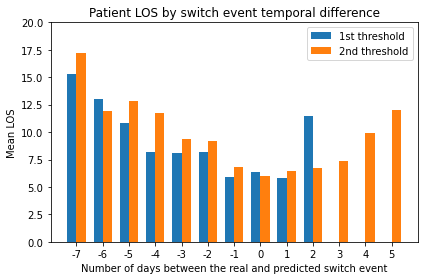

In [17]:
# Decided to go with -7 to 5 as good range for both plots

labels = ['-7', '-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5']

lb_los_mean = [15.337600,
13.047653,
10.831625,
8.154610,
8.109875,
8.160611,
5.882808,
6.351469,
5.860873,
11.497346, 0, 0, 0]

ub_los_mean =[17.244618, 11.954979,
12.811348,
11.724370,
9.327883,
9.215769,
6.822144,
5.973129,
6.443774,
6.700291,
7.330114, 9.925573, 11.981539]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lb_los_mean, width, label='1st threshold')#, yerr=po_error, ecolor='black', capsize=10)
rects2 = ax.bar(x + width/2, ub_los_mean, width, label='2nd threshold')#, yerr=iv_error, ecolor='black', capsize=10)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean LOS')
ax.set_title('Patient LOS by switch event temporal difference')
ax.set_xlabel('Number of days between the real and predicted switch event')

ax.set_ylim(0,20)

ax.set_xticks(x, labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()